In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# TSNE Implementation

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Transformation and MNIST data loading
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Filter to keep only labels 0-3
indices = [i for i, (img, label) in enumerate(full_dataset) if label in [0, 1, 2, 3]]
dataset = Subset(full_dataset, indices)

train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 38202752.06it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1173238.42it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 10849069.75it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2481506.94it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [19]:
import torch
import torch.nn as nn

class MyDNN(nn.Module):
    def __init__(self):
        super(MyDNN, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.classifier = nn.Linear(128, 4)  # Assuming 4 classes for digits 0-3

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image
        features = self.feature_extractor(x)
        logits = self.classifier(features)
        return logits, features

# Instantiate and move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyDNN().to(device)

In [20]:
model.eval()  # Set the model to evaluation mode
features_before = []  # To store penultimate layer features
features_after = []   # To store classifier head outputs (logits)
labels_list = []      # To store corresponding labels

with torch.no_grad():  # Disable gradient computation
    for data, labels in train_loader:
        data = data.to(device)
        logits, before_classifier = model(data)
        features_before.append(before_classifier.cpu().numpy())
        features_after.append(logits.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

# Convert list to numpy arrays for easier handling in t-SNE
features_before = np.concatenate(features_before)
features_after = np.concatenate(features_after)
labels_list = np.array(labels_list)

In [ ]:
from cuml.manifold import TSNE
import matplotlib.pyplot as plt

# Use RAPIDS cuML's TSNE
tsne = TSNE(n_components=2, method='barnes_hut', random_state=42)

# Perform t-SNE on the features from the penultimate layer
tsne_results_before = tsne.fit_transform(features_before)

# Perform t-SNE on the features from the classifier outputs (logits)
tsne_results_after = tsne.fit_transform(features_after)

# Helper function to plot t-SNE results
def plot_tsne(tsne_data, labels, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()

### 2D Visualisations

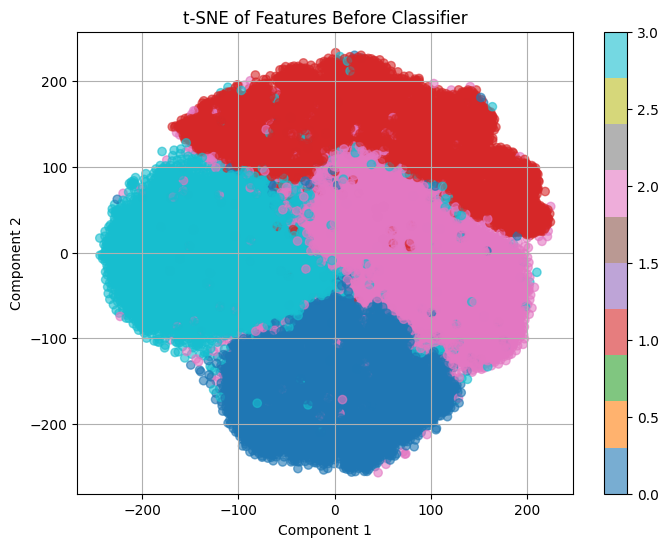

In [6]:
# Plotting the t-SNE results
plot_tsne(tsne_results_before, labels_list, 't-SNE of Features Before Classifier')

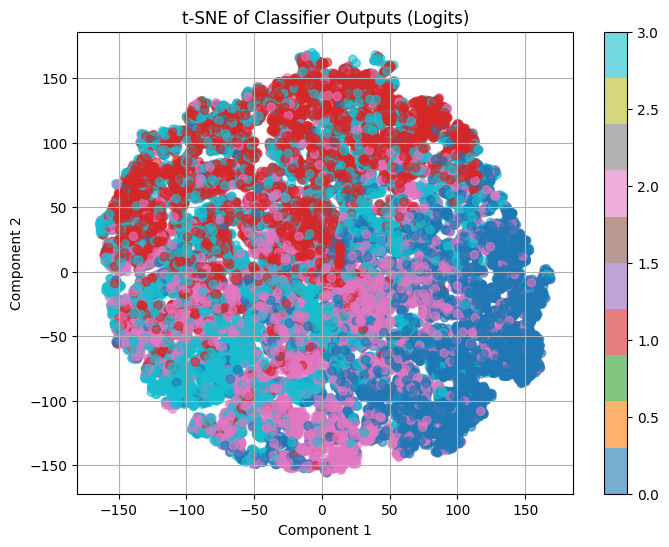

In [7]:

plot_tsne(tsne_results_after, labels_list, 't-SNE of Classifier Outputs (Logits)')

## 3D Visualisation - took too long on Kaggle or Colab GPUS, hence discarded

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Assume features_before and features_after are already defined and available

# Initialize t-SNE with 3 components for 3D visualization using Scikit-learn
tsne = TSNE(n_components=3, random_state=42)

# Perform t-SNE on the penultimate layer features
tsne_results_before = tsne.fit_transform(features_before)

# Perform t-SNE on the classifier output features
tsne_results_after = tsne.fit_transform(features_after)

def plot_tsne_3d(tsne_data, labels, title):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(tsne_data[:, 0], tsne_data[:, 1], tsne_data[:, 2], c=labels, cmap='tab10', alpha=0.6)
    cbar = fig.colorbar(scatter)
    cbar.set_label('Class Labels')
    ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.show()

# Plotting the 3D t-SNE results
plot_tsne_3d(tsne_results_before, labels_list, '3D t-SNE of Features Before Classifier')

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from cuml.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Dataset Setup with Custom Labeling
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Adjust the dataset to only include and modify labels 0-3, 4, 5 (4 and 5 relabeled to 3)
indices = [i for i, (img, label) in enumerate(full_dataset) if label in [0, 1, 2, 3, 4, 5]]
subset_dataset = Subset(full_dataset, indices)

def relabel_dataset(dataset):
    new_labels = []
    for _, label in dataset:
        new_labels.append(label if label < 4 else 3)
    return new_labels

labels = relabel_dataset(subset_dataset)
train_loader = DataLoader(subset_dataset, batch_size=64, shuffle=True)


In [9]:

# Step 2: Define the Model
class MyDNN(nn.Module):
    def __init__(self):
        super(MyDNN, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.classifier = nn.Linear(128, 4)  # 4 classes (0-3 with 4 and 5 relabeled as 3)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image
        features = self.feature_extractor(x)
        logits = self.classifier(features)
        return logits, features

# Instantiate and move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyDNN().to(device)


In [10]:

# Step 3: Feature Extraction
model.eval()  # Set the model to evaluation mode
features_before = []  # To store penultimate layer features
features_after = []   # To store classifier outputs (logits)

with torch.no_grad():
    for data, target in train_loader:
        data = data.to(device)
        logits, before_classifier = model(data)
        features_before.append(before_classifier.cpu().numpy())
        features_after.append(logits.cpu().numpy())

features_before = np.concatenate(features_before)
features_after = np.concatenate(features_after)


[W] [04:05:05.258845] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
[W] [04:05:07.797531] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


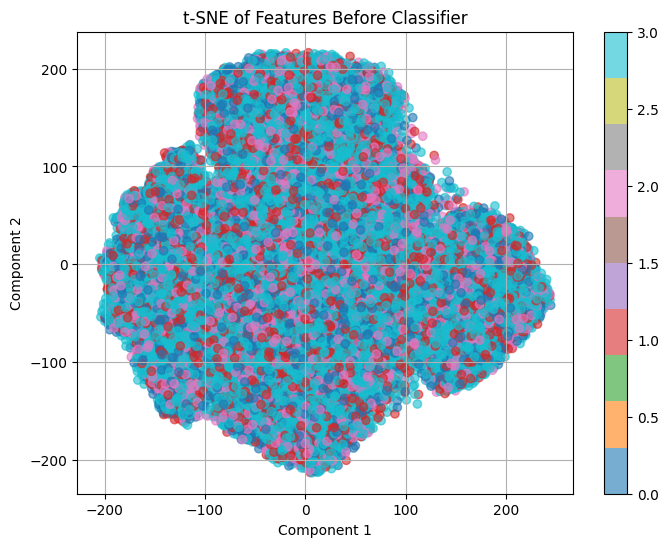

In [11]:

# Step 4: GPU-accelerated t-SNE and Plotting
tsne = TSNE(n_components=2, method='barnes_hut', random_state=42)

# Perform t-SNE on the features from the penultimate layer
tsne_results_before = tsne.fit_transform(features_before)

# Perform t-SNE on the features from the classifier outputs (logits)
tsne_results_after = tsne.fit_transform(features_after)

def plot_tsne(tsne_data, labels, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()

# Plotting the t-SNE results
plot_tsne(tsne_results_before, labels, 't-SNE of Features Before Classifier')


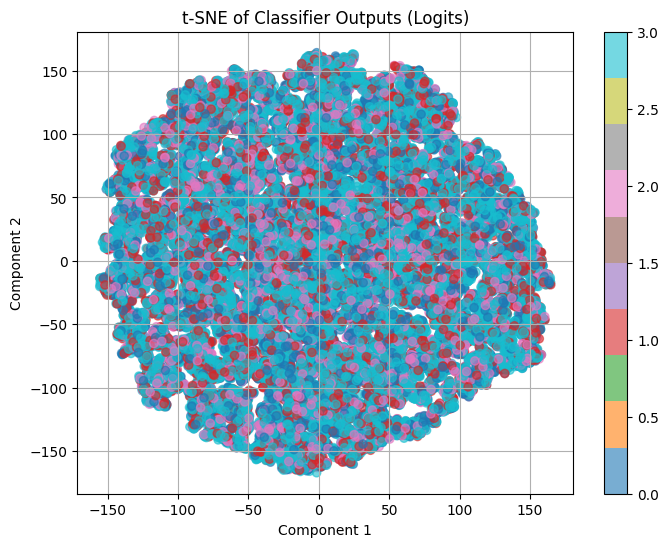

In [12]:

plot_tsne(tsne_results_after, labels, 't-SNE of Classifier Outputs (Logits)')

[W] [04:07:26.237005] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
[W] [04:07:28.831306] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


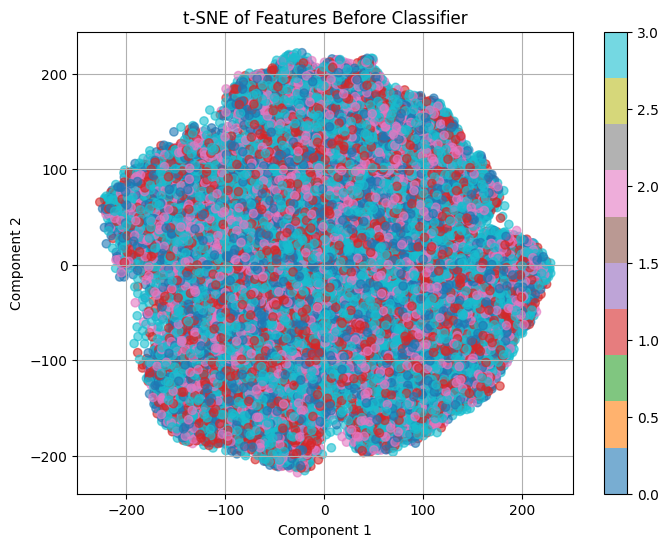

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from cuml.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Dataset Setup with Custom Labeling
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Adjust the dataset to only include and modify labels 0-3, 4 (4 relabeled to 3)
indices = [i for i, (img, label) in enumerate(full_dataset) if label in [0, 1, 2, 3, 4]]
subset_dataset = Subset(full_dataset, indices)

def relabel_dataset(dataset):
    new_labels = []
    for _, label in dataset:
        new_labels.append(label if label < 4 else 3)
    return new_labels

labels = relabel_dataset(subset_dataset)
train_loader = DataLoader(subset_dataset, batch_size=64, shuffle=True)

# Step 2: Define the Model
class MyDNN(nn.Module):
    def __init__(self):
        super(MyDNN, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.classifier = nn.Linear(128, 4)  # 4 classes (0-3 with 4 and 5 relabeled as 3)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image
        features = self.feature_extractor(x)
        logits = self.classifier(features)
        return logits, features

# Instantiate and move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyDNN().to(device)

# Step 3: Feature Extraction
model.eval()  # Set the model to evaluation mode
features_before = []  # To store penultimate layer features
features_after = []   # To store classifier outputs (logits)

with torch.no_grad():
    for data, target in train_loader:
        data = data.to(device)
        logits, before_classifier = model(data)
        features_before.append(before_classifier.cpu().numpy())
        features_after.append(logits.cpu().numpy())

features_before = np.concatenate(features_before)
features_after = np.concatenate(features_after)

# Step 4: GPU-accelerated t-SNE and Plotting
tsne = TSNE(n_components=2, method='barnes_hut', random_state=42)

# Perform t-SNE on the features from the penultimate layer
tsne_results_before = tsne.fit_transform(features_before)

# Perform t-SNE on the features from the classifier outputs (logits)
tsne_results_after = tsne.fit_transform(features_after)

def plot_tsne(tsne_data, labels, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()

# Plotting the t-SNE results
plot_tsne(tsne_results_before, labels, 't-SNE of Features Before Classifier')

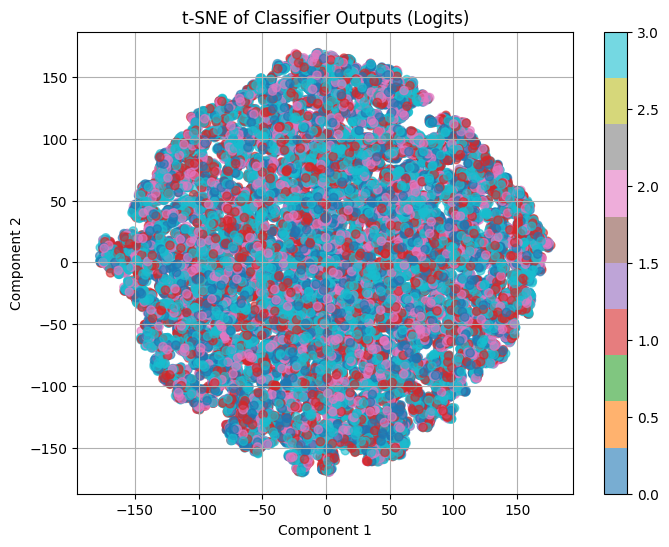

In [14]:
plot_tsne(tsne_results_after, labels, 't-SNE of Classifier Outputs (Logits)')

[W] [04:09:45.869278] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
[W] [04:09:48.933605] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


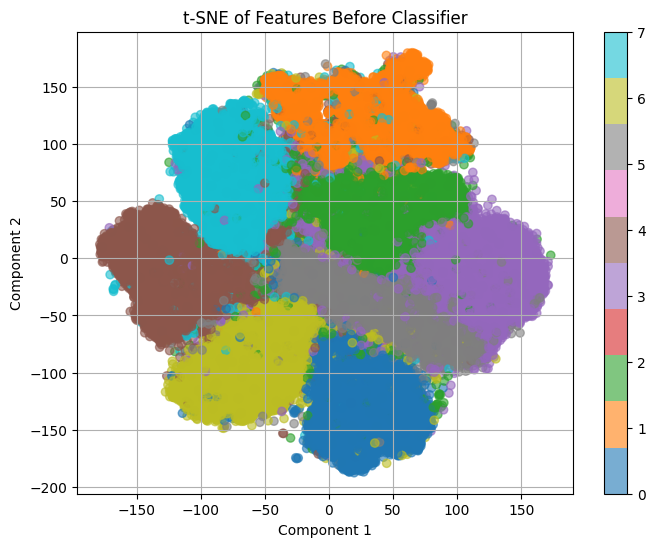

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from cuml.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Dataset Setup
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Include only labels 0-7
indices = [i for i, (img, label) in enumerate(full_dataset) if label in range(8)]
subset_dataset = Subset(full_dataset, indices)
train_loader = DataLoader(subset_dataset, batch_size=64, shuffle=True)

# Step 2: Define the Model
class MyDNN(nn.Module):
    def __init__(self):
        super(MyDNN, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.classifier = nn.Linear(128, 8)  # 8 classes for digits 0-7

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image
        features = self.feature_extractor(x)
        logits = self.classifier(features)
        return logits, features

# Instantiate and move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyDNN().to(device)

# Optional: Training Step Here (model training code would go here if model is not pre-trained)

# Step 3: Feature Extraction
model.eval()  # Set the model to evaluation mode
features_before = []  # To store penultimate layer features
features_after = []   # To store classifier outputs (logits)
labels_list = []      # To store corresponding labels

with torch.no_grad():
    for data, labels in train_loader:
        data = data.to(device)
        logits, before_classifier = model(data)
        features_before.append(before_classifier.cpu().numpy())
        features_after.append(logits.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

features_before = np.concatenate(features_before)
features_after = np.concatenate(features_after)
labels_list = np.array(labels_list)

# Step 4: GPU-accelerated t-SNE and Plotting
tsne = TSNE(n_components=2, method='barnes_hut', random_state=42)

# Perform t-SNE on the features from the penultimate layer
tsne_results_before = tsne.fit_transform(features_before)

# Perform t-SNE on the features from the classifier outputs (logits)
tsne_results_after = tsne.fit_transform(features_after)

def plot_tsne(tsne_data, labels, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()

# Plotting the t-SNE results
plot_tsne(tsne_results_before, labels_list, 't-SNE of Features Before Classifier')

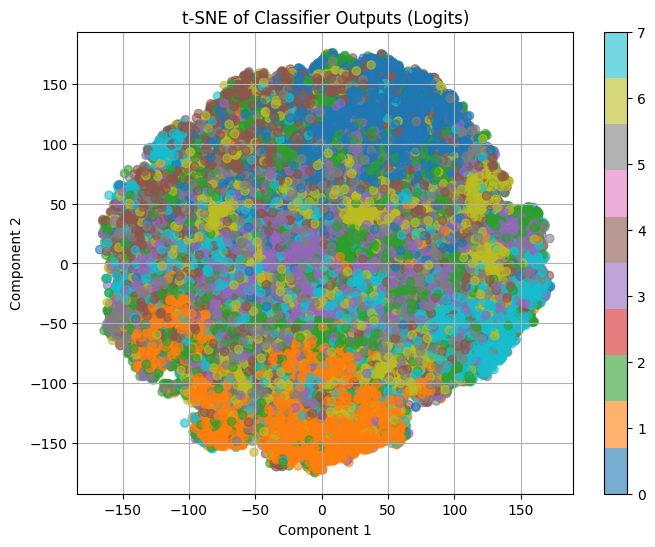

In [16]:
plot_tsne(tsne_results_after, labels_list, 't-SNE of Classifier Outputs (Logits)')

### 3D Visualisation for all 10 classes, too long did not complete its execution

In [18]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Assume features_before and features_after are already defined and available

# Initialize t-SNE with 3 components for 3D visualization using Scikit-learn
tsne = TSNE(n_components=3, random_state=42)

# Perform t-SNE on the penultimate layer features
tsne_results_before = tsne.fit_transform(features_before)

# Perform t-SNE on the classifier output features
tsne_results_after = tsne.fit_transform(features_after)

def plot_tsne_3d(tsne_data, labels, title):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(tsne_data[:, 0], tsne_data[:, 1], tsne_data[:, 2], c=labels, cmap='tab10', alpha=0.6)
    cbar = fig.colorbar(scatter)
    cbar.set_label('Class Labels')
    ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.show()

# Plotting the 3D t-SNE results
plot_tsne_3d(tsne_results_before, labels_list, '3D t-SNE of Features Before Classifier')


KeyboardInterrupt: 

In [ ]:

plot_tsne_3d(tsne_results_after, labels_list, '3D t-SNE of Classifier Outputs (Logits)')

# UMAP Implementation

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5


I0000 00:00:1732598930.603153     243 service.cc:145] XLA service 0x7f5e7c00e9e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732598930.603219     243 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732598930.603252     243 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 99/774 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8151 - loss: 0.5370

I0000 00:00:1732598932.055639     243 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


774/774 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9382 - loss: 0.1955
Epoch 2/5
774/774 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9883 - loss: 0.0366
Epoch 3/5
774/774 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9937 - loss: 0.0202
Epoch 4/5
774/774 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9953 - loss: 0.0136
Epoch 5/5
774/774 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9980 - loss: 0.0075
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


AttributeError: 'Series' object has no attribute 'to_array'

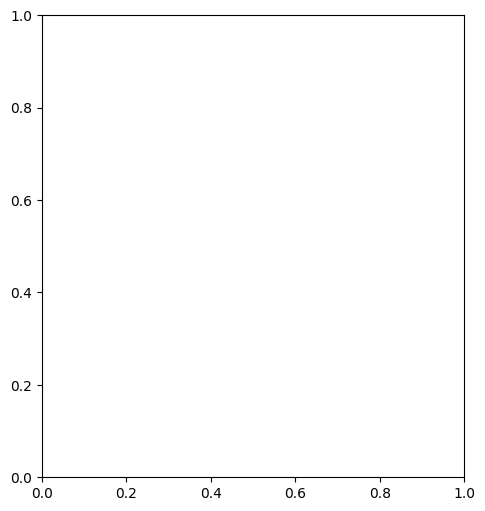

In [22]:
import cudf
import cuml
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

# Load MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
mask = np.isin(y_train, [0, 1, 2, 3])
x_train, y_train = x_train[mask], y_train[mask]
x_train = x_train.reshape(x_train.shape[0], -1).astype('float32') / 255

mask_test = np.isin(y_test, [0, 1, 2, 3])
x_test, y_test = x_test[mask_test], y_test[mask_test]
x_test = x_test.reshape(x_test.shape[0], -1).astype('float32') / 255

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

# Build the DNN model
model = Sequential([
    Flatten(input_shape=(784,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(4, activation='linear'),  # Features just before classifier head
    Dense(4, activation='softmax')  # Features just after classifier head
])

# Compile and train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5, batch_size=32)


130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


KeyError: '0'

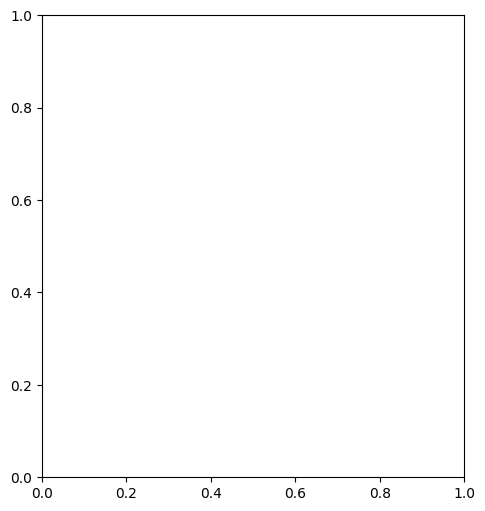

In [24]:

# Extract features from both layers
intermediate_layer_model = Sequential(model.layers[:-1])  # Extract up to the last dense linear layer
features_before = intermediate_layer_model.predict(x_test)
features_after = model.predict(x_test)

# Convert features to cuDF DataFrame for UMAP
features_before_gdf = cudf.DataFrame(features_before)
features_after_gdf = cudf.DataFrame(features_after)

# Apply UMAP
umap_transformer = cuml.UMAP(n_components=2)
umap_features_before = umap_transformer.fit_transform(features_before_gdf)
umap_features_after = umap_transformer.fit_transform(features_after_gdf)

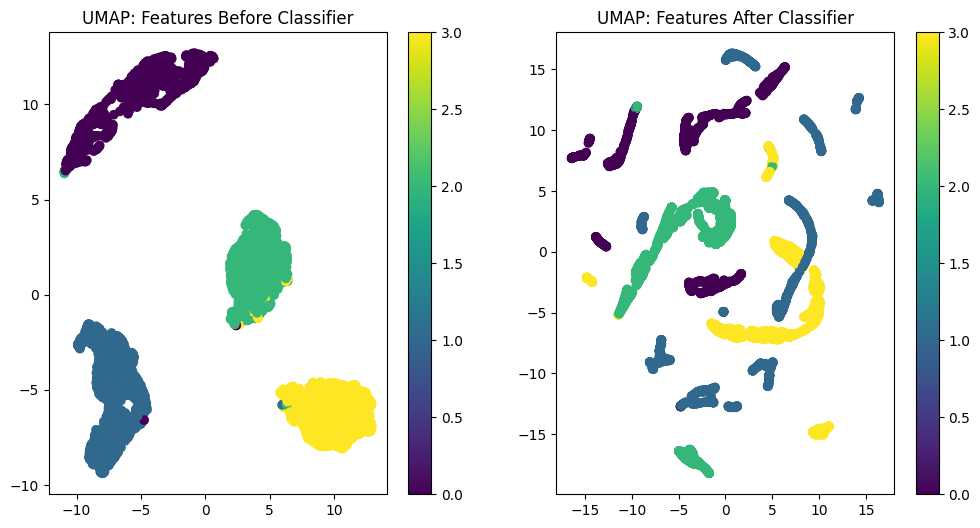

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot features before classifier head
plt.subplot(1, 2, 1)
plt.scatter(umap_features_before[0].to_numpy(), umap_features_before[1].to_numpy(), c=np.argmax(y_test, axis=1), cmap='viridis')
plt.colorbar()  # Optionally add a colorbar
plt.title('UMAP: Features Before Classifier')

# Plot features after classifier head
plt.subplot(1, 2, 2)
plt.scatter(umap_features_after[0].to_numpy(), umap_features_after[1].to_numpy(), c=np.argmax(y_test, axis=1), cmap='viridis')
plt.colorbar()  # Optionally add a colorbar
plt.title('UMAP: Features After Classifier')

plt.show()


# Final Function created for Visualisation

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import cudf
import cuml
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

def analyze_mnist_with_umap(max_label):
    # Load MNIST data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    mask = np.isin(y_train, range(max_label + 1))
    x_train, y_train = x_train[mask], y_train[mask]
    x_train = x_train.reshape(x_train.shape[0], -1).astype('float32') / 255

    mask_test = np.isin(y_test, range(max_label + 1))
    x_test, y_test = x_test[mask_test], y_test[mask_test]
    x_test = x_test.reshape(x_test.shape[0], -1).astype('float32') / 255

    # One-hot encode labels
    y_train = to_categorical(y_train, num_classes=max_label + 1)
    y_test = to_categorical(y_test, num_classes=max_label + 1)

    # Build the DNN model
    model = Sequential([
        Flatten(input_shape=(784,)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(max_label + 1, activation='linear'),  # Features just before classifier head
        Dense(max_label + 1, activation='softmax')  # Features just after classifier head
    ])

    # Compile and train the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=5, batch_size=32)

    # Extract features from both layers
    intermediate_layer_model = Sequential(model.layers[:-1])  # Extract up to the last dense linear layer
    features_before = intermediate_layer_model.predict(x_test)
    features_after = model.predict(x_test)

    # Convert features to cuDF DataFrame for UMAP
    features_before_gdf = cudf.DataFrame(features_before)
    features_after_gdf = cudf.DataFrame(features_after)

    # Apply UMAP
    umap_transformer = cuml.UMAP(n_components=2)
    umap_features_before = umap_transformer.fit_transform(features_before_gdf)
    umap_features_after = umap_transformer.fit_transform(features_after_gdf)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(umap_features_before[0].to_numpy(), umap_features_before[1].to_numpy(), c=np.argmax(y_test, axis=1), cmap='viridis')
    plt.colorbar()
    plt.title('UMAP: Features Before Classifier for 0-{}'.format(max_label))

    plt.subplot(1, 2, 2)
    plt.scatter(umap_features_after[0].to_numpy(), umap_features_after[1].to_numpy(), c=np.argmax(y_test, axis=1), cmap='viridis')
    plt.colorbar()
    plt.title('UMAP: Features After Classifier for 0-{}'.format(max_label))

    plt.show()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9543 - loss: 0.1436
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9924 - loss: 0.0201
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9972 - loss: 0.0104
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9966 - loss: 0.0091
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9984 - loss: 0.0045
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


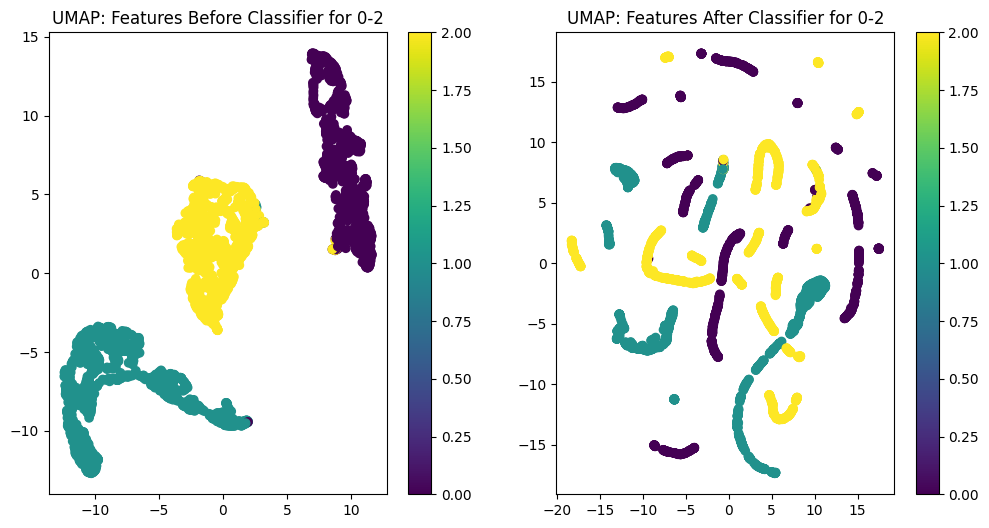

In [35]:
# Call the function for different label ranges
analyze_mnist_with_umap(2)  # For labels 0-2

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
774/774 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9352 - loss: 0.1936
Epoch 2/5
774/774 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9883 - loss: 0.0371
Epoch 3/5
774/774 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9941 - loss: 0.0182
Epoch 4/5
774/774 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9960 - loss: 0.0126
Epoch 5/5
774/774 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9963 - loss: 0.0134
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


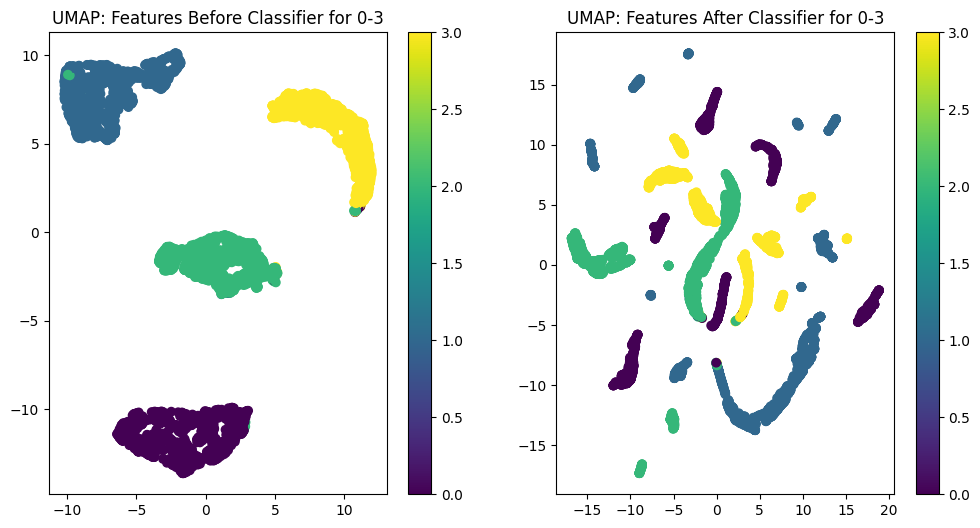

In [34]:
# Call the function for different label ranges
analyze_mnist_with_umap(3)  # For labels 0-3

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
957/957 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9053 - loss: 0.2709
Epoch 2/5
957/957 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9871 - loss: 0.0434
Epoch 3/5
957/957 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9910 - loss: 0.0264
Epoch 4/5
957/957 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9936 - loss: 0.0185
Epoch 5/5
957/957 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9969 - loss: 0.0106
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


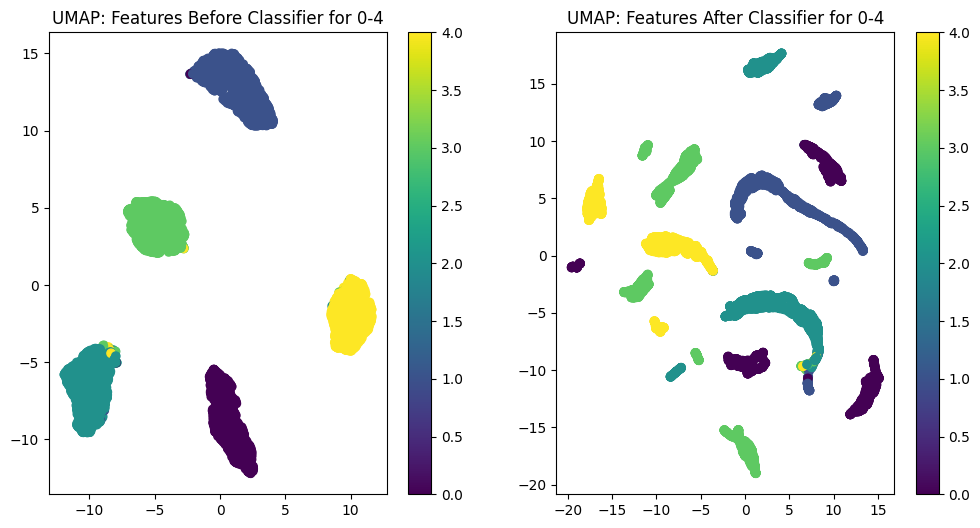

In [33]:
# Call the function for different label ranges
analyze_mnist_with_umap(4)  # For labels 0-4

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8960 - loss: 0.3283
Epoch 2/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9815 - loss: 0.0574
Epoch 3/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9903 - loss: 0.0333
Epoch 4/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9922 - loss: 0.0226
Epoch 5/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9946 - loss: 0.0159
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


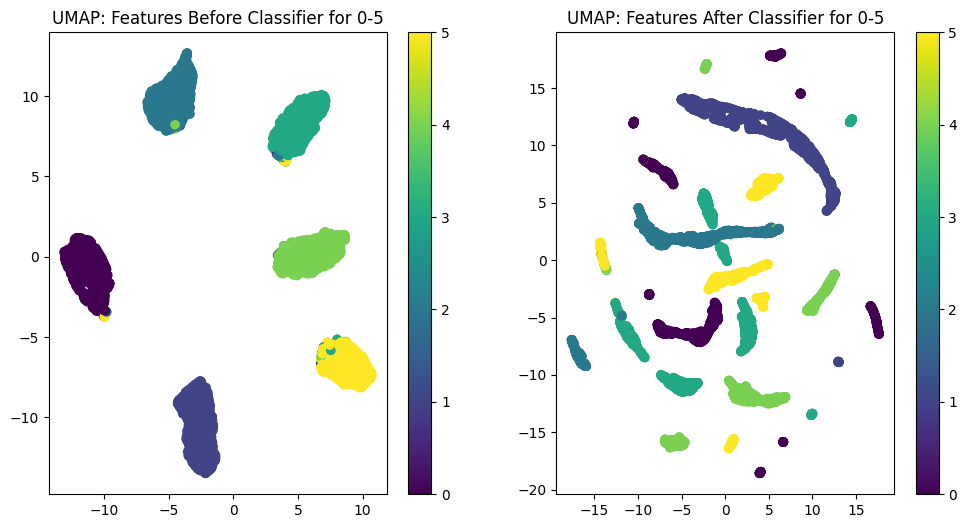

In [28]:
# Call the function for different label ranges
analyze_mnist_with_umap(5)  # For labels 0-5

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8979 - loss: 0.3378
Epoch 2/5
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9794 - loss: 0.0634
Epoch 3/5
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9871 - loss: 0.0396
Epoch 4/5
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9908 - loss: 0.0273
Epoch 5/5
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9931 - loss: 0.0207
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


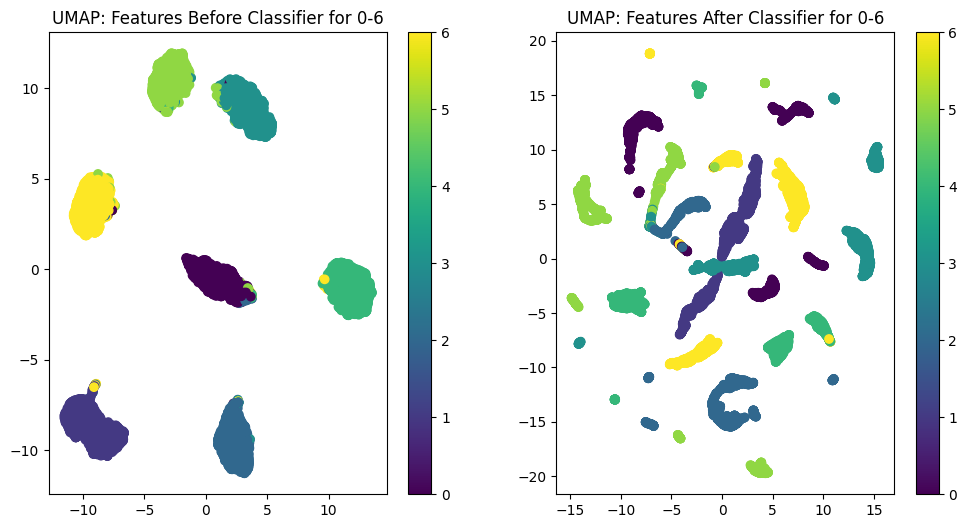

In [32]:
# Call the function for different label ranges
analyze_mnist_with_umap(6)  # For labels 0-6

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9072 - loss: 0.3310
Epoch 2/5
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9783 - loss: 0.0685
Epoch 3/5
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9850 - loss: 0.0468
Epoch 4/5
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9911 - loss: 0.0291
Epoch 5/5
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9921 - loss: 0.0243
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


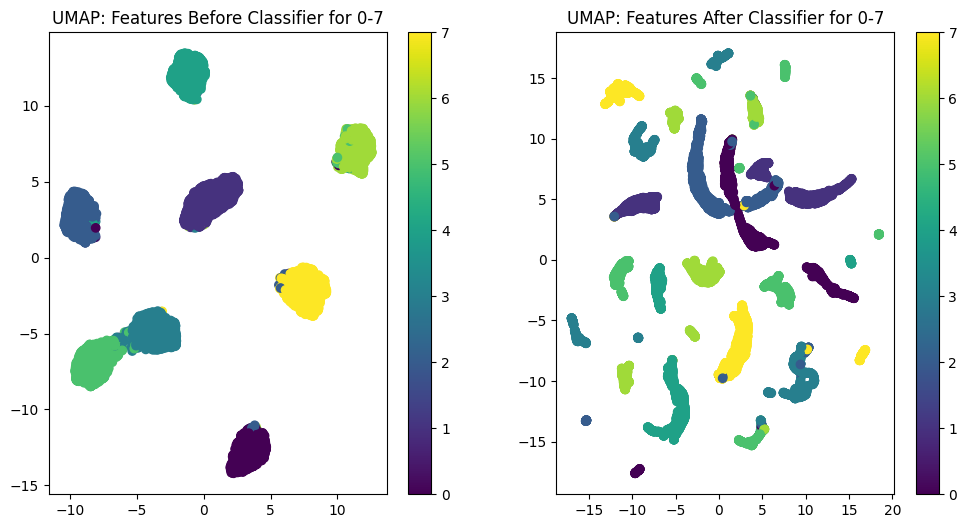

In [29]:
analyze_mnist_with_umap(7)  # For labels 0-7

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1690/1690 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8752 - loss: 0.4098
Epoch 2/5
1690/1690 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9752 - loss: 0.0834
Epoch 3/5
1690/1690 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9836 - loss: 0.0525
Epoch 4/5
1690/1690 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9881 - loss: 0.0388
Epoch 5/5
1690/1690 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9904 - loss: 0.0302
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


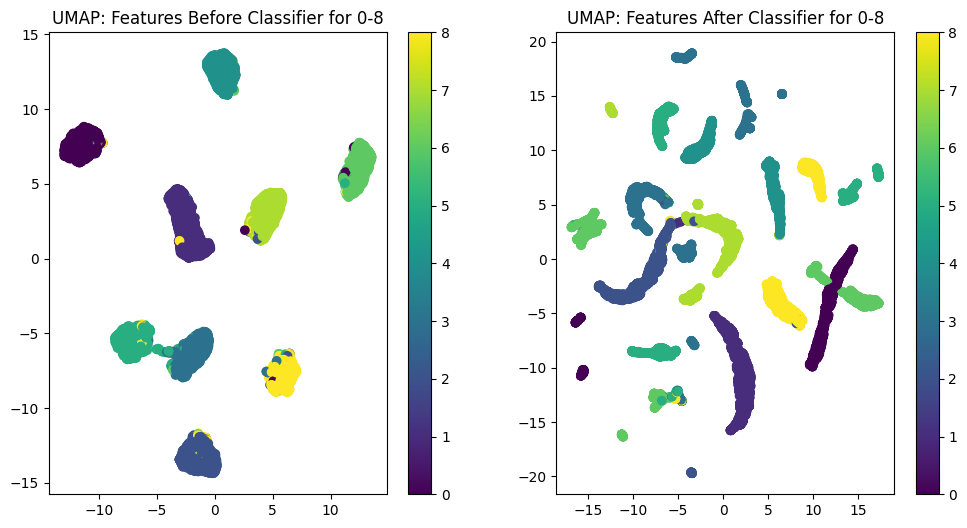

In [31]:
analyze_mnist_with_umap(8)  # For labels 0-8

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8640 - loss: 0.4558
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9680 - loss: 0.1051
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9784 - loss: 0.0697
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9849 - loss: 0.0512
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9879 - loss: 0.0378
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


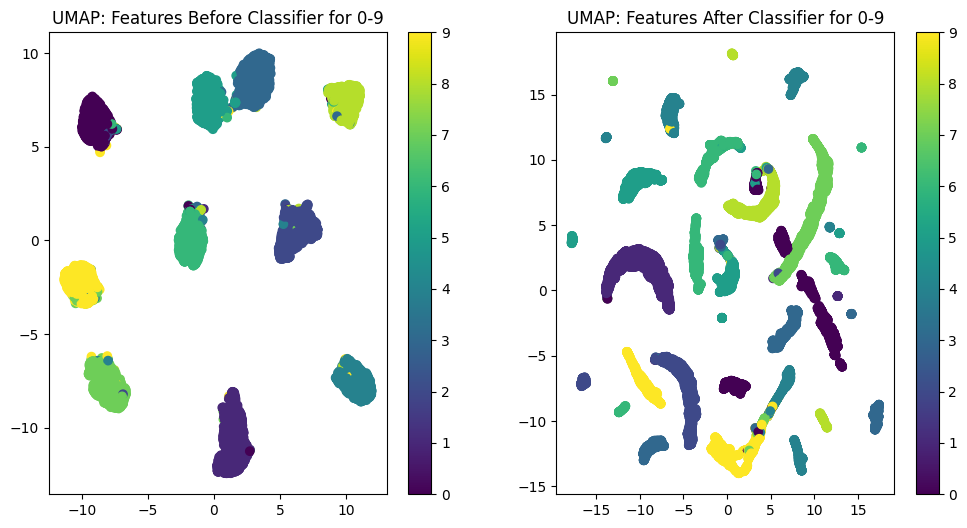

In [30]:

analyze_mnist_with_umap(9)  # For labels 0-9

# t-NSE Implementation

In [40]:
!pip install scikit-learn

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.keras.datasets import mnist  # Corrected import statement
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

def analyze_mnist_with_tsne(max_label):
    # Load MNIST data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()  # Corrected usage
    mask = np.isin(y_train, range(max_label + 1))
    x_train, y_train = x_train[mask], y_train[mask]
    x_train = x_train.reshape(x_train.shape[0], -1).astype('float32') / 255

    mask_test = np.isin(y_test, range(max_label + 1))
    x_test, y_test = x_test[mask_test], y_test[mask_test]
    x_test = x_test.reshape(x_test.shape[0], -1).astype('float32') / 255

    # One-hot encode labels
    y_train = to_categorical(y_train, num_classes=max_label + 1)
    y_test = to_categorical(y_test, num_classes=max_label + 1)

    # Build the DNN model
    model = Sequential([
        Flatten(input_shape=(784,)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(max_label + 1, activation='linear'),  # Features just before classifier head
        Dense(max_label + 1, activation='softmax')  # Features just after classifier head
    ])

    # Compile and train the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=5, batch_size=32)

    # Extract features from both layers
    intermediate_layer_model = Sequential(model.layers[:-1])  # Extract up to the last dense linear layer
    features_before = intermediate_layer_model.predict(x_test)
    features_after = model.predict(x_test)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_features_before = tsne.fit_transform(features_before)
    tsne_features_after = tsne.fit_transform(features_after)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(tsne_features_before[:, 0], tsne_features_before[:, 1], c=np.argmax(y_test, axis=1), cmap='viridis')
    plt.colorbar()
    plt.title('t-SNE: Features Before Classifier for 0-{}'.format(max_label))

    plt.subplot(1, 2, 2)
    plt.scatter(tsne_features_after[:, 0], tsne_features_after[:, 1], c=np.argmax(y_test, axis=1), cmap='viridis')
    plt.colorbar()
    plt.title('t-SNE: Features After Classifier for 0-{}'.format(max_label))

    plt.show()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9702 - loss: 0.1155
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9936 - loss: 0.0194
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9964 - loss: 0.0107
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9980 - loss: 0.0082
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9972 - loss: 0.0076
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


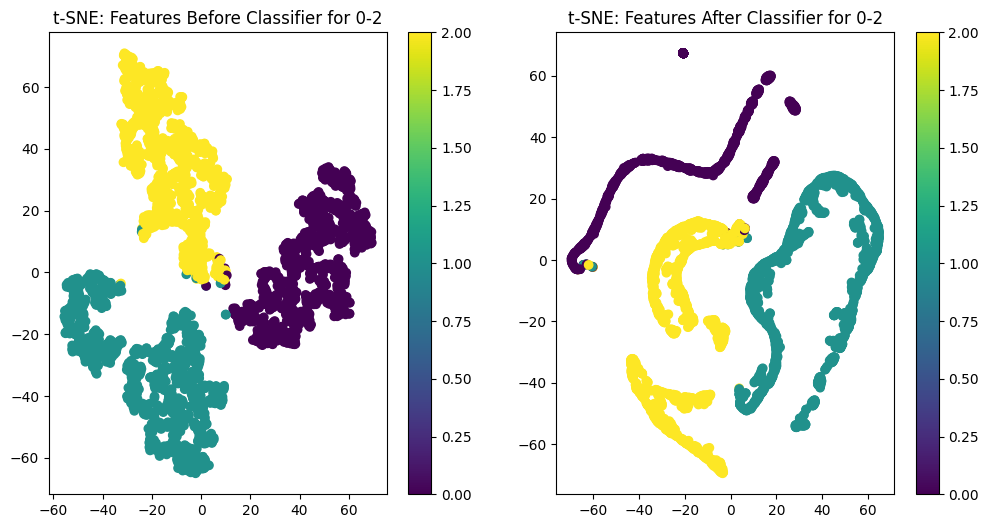

In [43]:
analyze_mnist_with_tsne(2)  

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
774/774 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9380 - loss: 0.1911
Epoch 2/5
774/774 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9879 - loss: 0.0387
Epoch 3/5
774/774 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9925 - loss: 0.0223
Epoch 4/5
774/774 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9957 - loss: 0.0133
Epoch 5/5
774/774 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9963 - loss: 0.0126
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


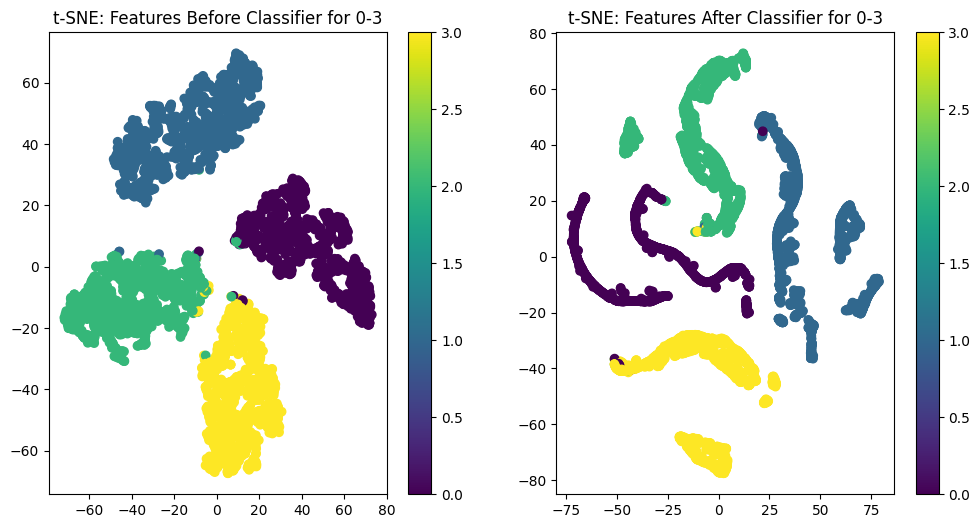

In [44]:
analyze_mnist_with_tsne(3)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
957/957 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9162 - loss: 0.2546
Epoch 2/5
957/957 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9878 - loss: 0.0400
Epoch 3/5
957/957 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9916 - loss: 0.0251
Epoch 4/5
957/957 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9946 - loss: 0.0150
Epoch 5/5
957/957 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9974 - loss: 0.0086
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


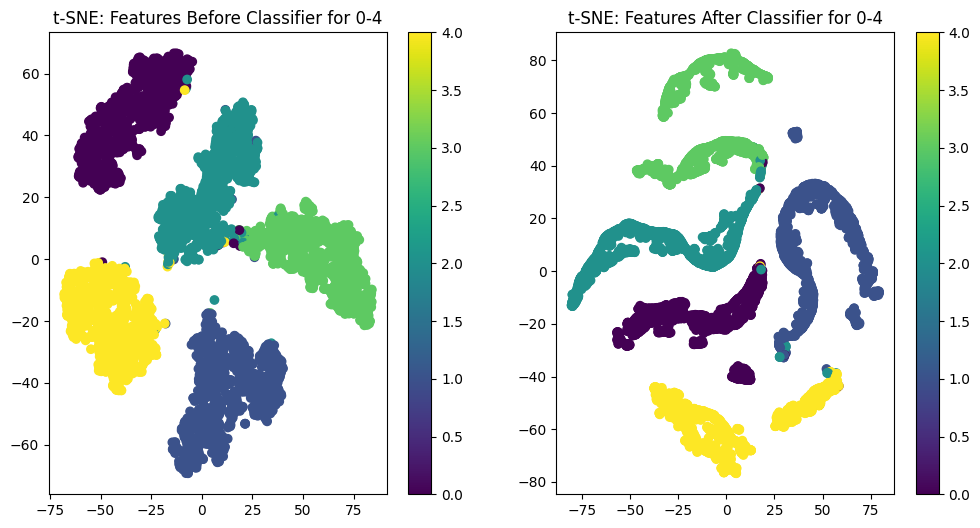

In [45]:

analyze_mnist_with_tsne(4)  

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9066 - loss: 0.2916
Epoch 2/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9817 - loss: 0.0549
Epoch 3/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9898 - loss: 0.0316
Epoch 4/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9927 - loss: 0.0221
Epoch 5/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9943 - loss: 0.0158
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


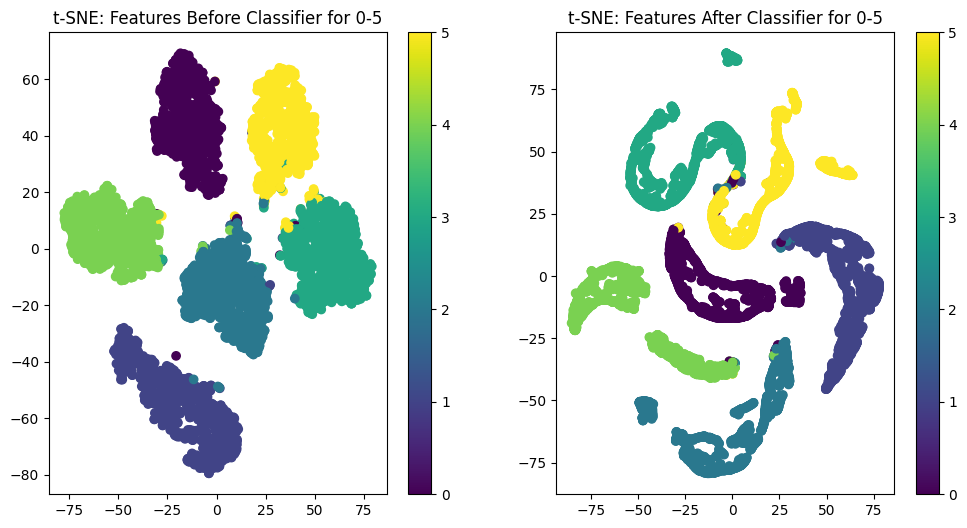

In [46]:

analyze_mnist_with_tsne(5)  

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8927 - loss: 0.3619
Epoch 2/5
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9811 - loss: 0.0618
Epoch 3/5
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9868 - loss: 0.0409
Epoch 4/5
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9900 - loss: 0.0291
Epoch 5/5
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9941 - loss: 0.0181
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


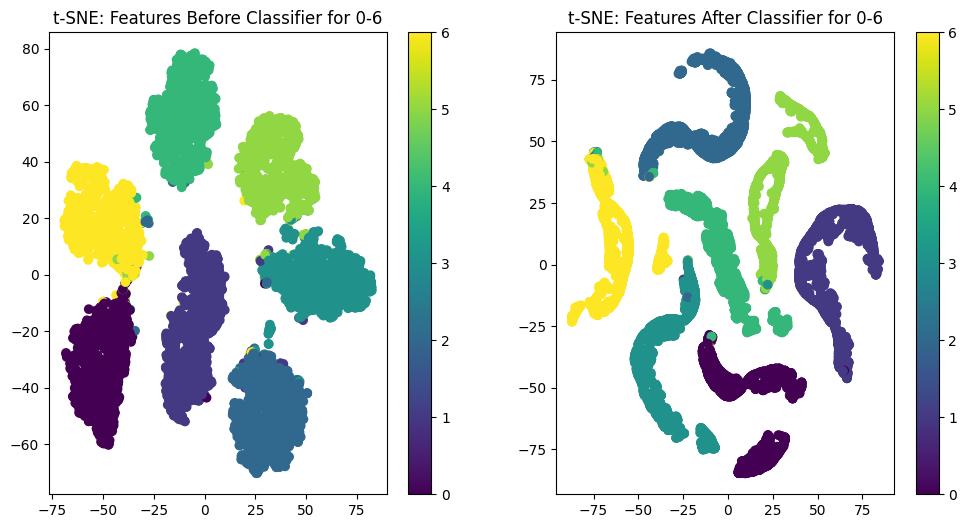

In [47]:

analyze_mnist_with_tsne(6)  

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8931 - loss: 0.3542
Epoch 2/5
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9787 - loss: 0.0685
Epoch 3/5
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9871 - loss: 0.0405
Epoch 4/5
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9900 - loss: 0.0302
Epoch 5/5
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9927 - loss: 0.0230
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


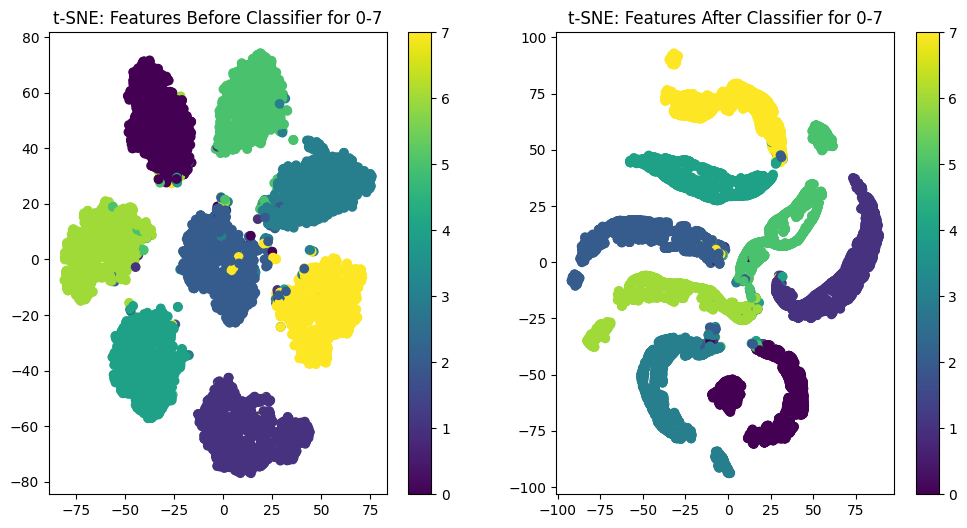

In [48]:

analyze_mnist_with_tsne(7)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1690/1690 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8857 - loss: 0.3802
Epoch 2/5
1690/1690 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9730 - loss: 0.0869
Epoch 3/5
1690/1690 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9814 - loss: 0.0598
Epoch 4/5
1690/1690 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9862 - loss: 0.0440
Epoch 5/5
1690/1690 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9899 - loss: 0.0315
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


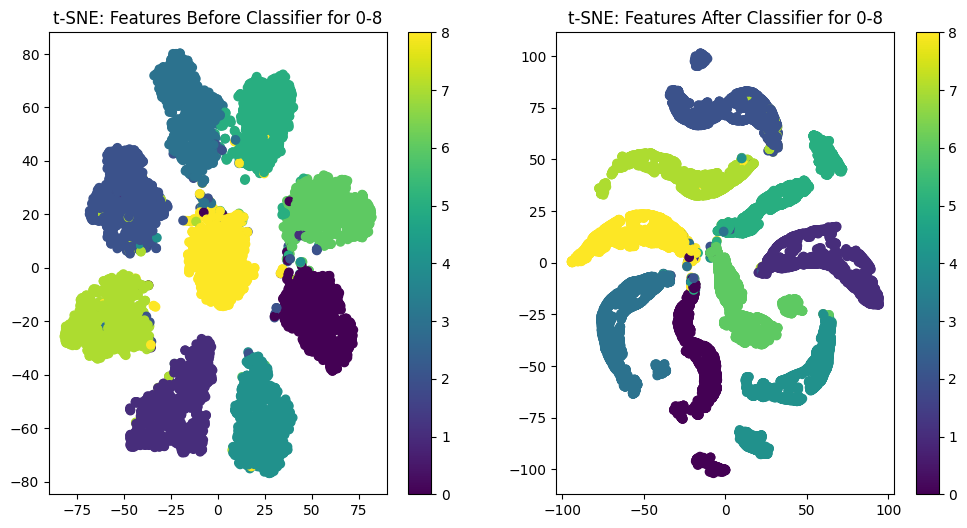

In [49]:
analyze_mnist_with_tsne(8)  

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8604 - loss: 0.4552
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9670 - loss: 0.1077
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9766 - loss: 0.0781
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9841 - loss: 0.0513
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9871 - loss: 0.0407
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


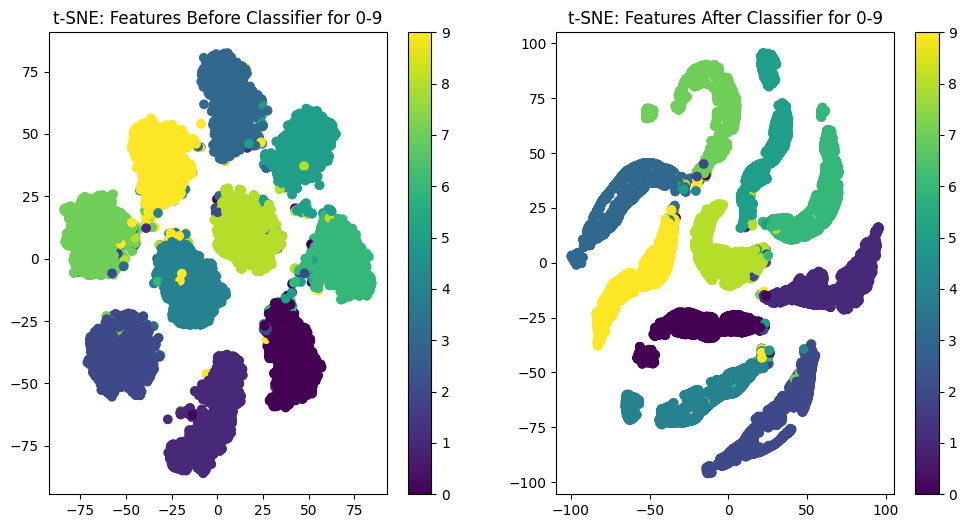

In [50]:

analyze_mnist_with_tsne(9)  

# Self-Organizing Maps (SOMs)
Improper Implementation or a bad Visualisation method comparitively

In [51]:
!pip install minisom

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.3-py3-none-any.whl size=11705 sha256=06d25e3565cfbfaa027cce86f41dbfa0dc868591141f75fb9fb7cff4f4f5cc33
  Stored in directory: /root/.cache/pip/wheels/96/98/a5/52dee3e8ed1dbfc4d77e4da41b6d89dd7ab9ead1b921e766f8
Successfully built minisom


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from minisom import MiniSom

def analyze_mnist_with_som(max_label):
    # Load MNIST data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    mask = np.isin(y_train, range(max_label + 1))
    x_train, y_train = x_train[mask], y_train[mask]
    x_train = x_train.reshape(x_train.shape[0], -1).astype('float32') / 255

    mask_test = np.isin(y_test, range(max_label + 1))
    x_test, y_test = x_test[mask_test], y_test[mask_test]
    x_test = x_test.reshape(x_test.shape[0], -1).astype('float32') / 255

    # One-hot encode labels
    y_train = to_categorical(y_train, num_classes=max_label + 1)
    y_test = to_categorical(y_test, num_classes=max_label + 1)

    # Build the DNN model
    model = Sequential([
        Flatten(input_shape=(784,)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(max_label + 1, activation='linear'),  # Features just before classifier head
        Dense(max_label + 1, activation='softmax')  # Features just after classifier head
    ])

    # Compile and train the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=5, batch_size=32)

    # Extract features from both layers
    intermediate_layer_model = Sequential(model.layers[:-1])
    features_before = intermediate_layer_model.predict(x_test)
    features_after = model.predict(x_test)

    # Initialize and train SOM
    som_side_dim = int(np.sqrt(5 * np.sqrt(features_before.shape[0])))  # heuristic for grid size
    som = MiniSom(som_side_dim, som_side_dim, features_before.shape[1], sigma=0.5, learning_rate=0.5)
    som.train(features_before, 500)  # trains the SOM with 500 iterations

    # Plotting the result
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.title('SOM: Features Before Classifier for 0-{}'.format(max_label))
    wmap = {}
    for i, x in enumerate(features_before):
        w = som.winner(x)
        wmap[w] = i
    plt.imshow(som.distance_map())  # shows the distance map from neurons in the SOM
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.title('SOM: Features After Classifier for 0-{}'.format(max_label))
    som.train(features_after, 500)  # trains the SOM again for features after the classifier
    plt.imshow(som.distance_map())
    plt.colorbar()

    plt.show()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
774/774 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9339 - loss: 0.2117
Epoch 2/5
774/774 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9880 - loss: 0.0359
Epoch 3/5
774/774 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9928 - loss: 0.0214
Epoch 4/5
774/774 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9966 - loss: 0.0111
Epoch 5/5
774/774 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9970 - loss: 0.0085
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


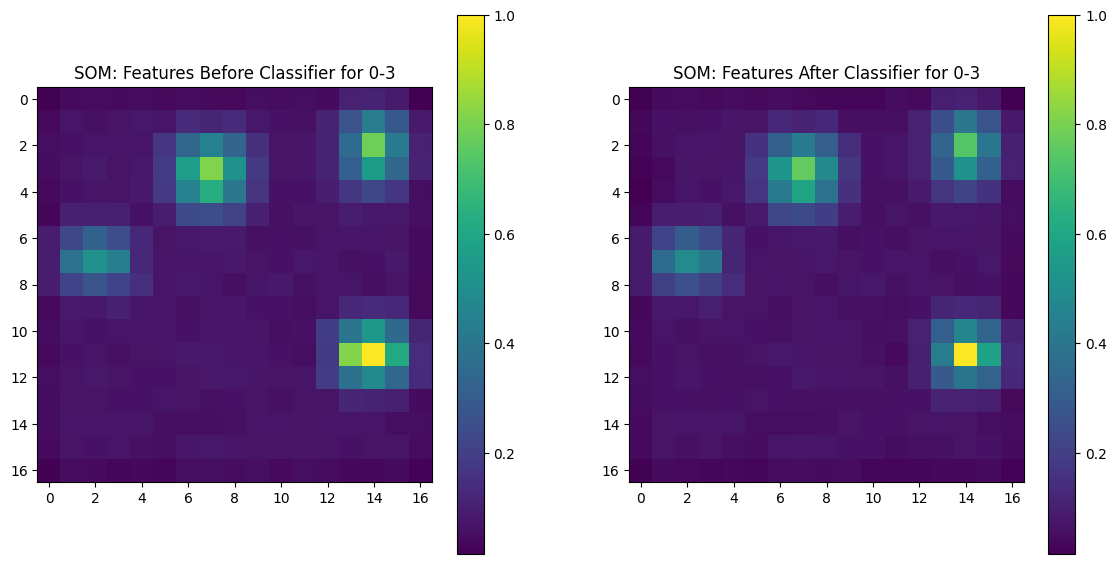

In [53]:

analyze_mnist_with_som(3)  # For labels 0-3

Epoch 1/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9110 - loss: 0.2976
Epoch 2/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9849 - loss: 0.0509
Epoch 3/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9900 - loss: 0.0306
Epoch 4/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9942 - loss: 0.0202
Epoch 5/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9958 - loss: 0.0130
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


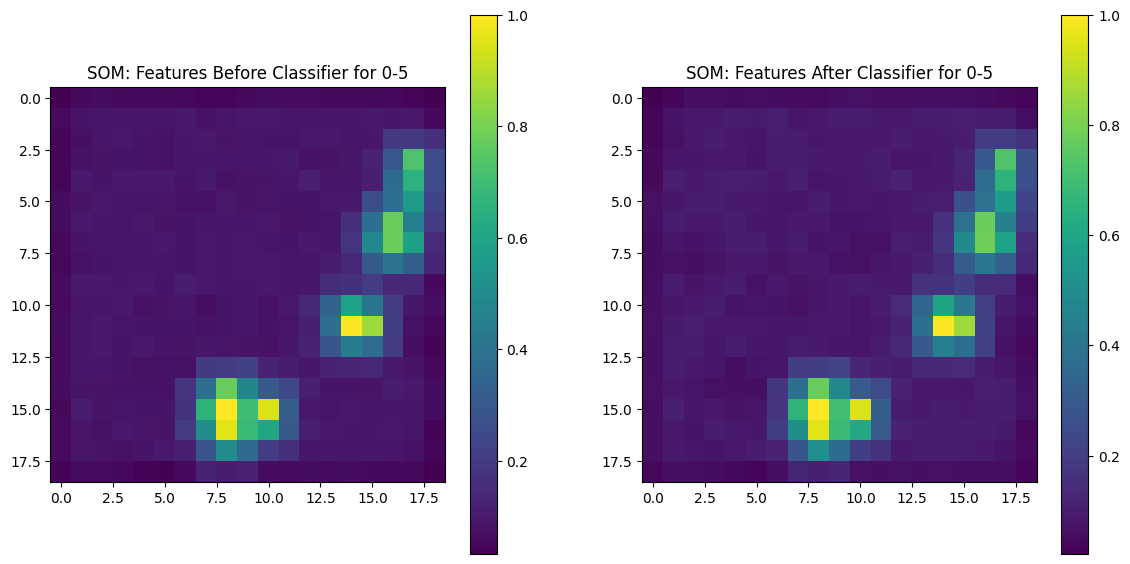

In [54]:

analyze_mnist_with_som(5)  # For labels 0-5

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8595 - loss: 0.4689
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9672 - loss: 0.1087
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9773 - loss: 0.0720
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9821 - loss: 0.0550
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9856 - loss: 0.0440
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


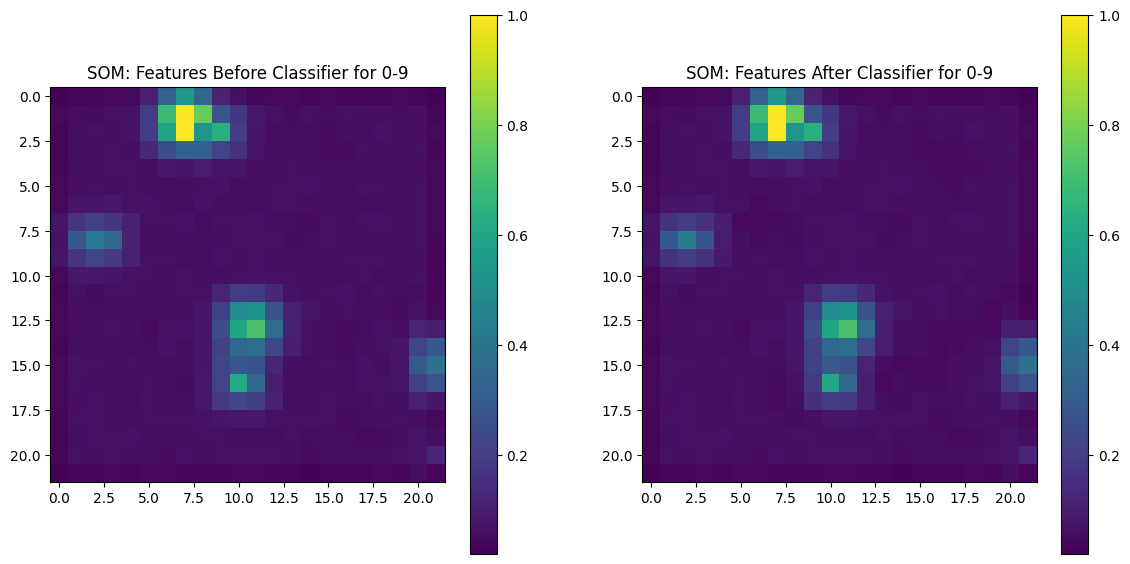

In [55]:

analyze_mnist_with_som(9)  # For labels 0-9

# Spectral Embedding

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import SpectralEmbedding
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

def analyze_mnist_with_spectral_embedding(max_label):
    # Load MNIST data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    mask = np.isin(y_train, range(max_label + 1))
    x_train, y_train = x_train[mask], y_train[mask]
    x_train = x_train.reshape(x_train.shape[0], -1).astype('float32') / 255

    mask_test = np.isin(y_test, range(max_label + 1))
    x_test, y_test = x_test[mask_test], y_test[mask_test]
    x_test = x_test.reshape(x_test.shape[0], -1).astype('float32') / 255

    # One-hot encode labels
    y_train = to_categorical(y_train, num_classes=max_label + 1)
    y_test = to_categorical(y_test, num_classes=max_label + 1)

    # Build the DNN model
    model = Sequential([
        Flatten(input_shape=(784,)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(max_label + 1, activation='linear'),  # Features just before classifier head
        Dense(max_label + 1, activation='softmax')  # Features just after classifier head
    ])

    # Compile and train the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=5, batch_size=32)

    # Extract features from both layers
    intermediate_layer_model = Sequential(model.layers[:-1])
    features_before = intermediate_layer_model.predict(x_test)
    features_after = model.predict(x_test)

    # Apply Spectral Embedding
    spectral_before = SpectralEmbedding(n_components=2, random_state=42)
    spectral_features_before = spectral_before.fit_transform(features_before)

    spectral_after = SpectralEmbedding(n_components=2, random_state=42)
    spectral_features_after = spectral_after.fit_transform(features_after)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(spectral_features_before[:, 0], spectral_features_before[:, 1], c=np.argmax(y_test, axis=1), cmap='viridis')
    plt.colorbar()
    plt.title('Spectral Embedding: Features Before Classifier for 0-{}'.format(max_label))

    plt.subplot(1, 2, 2)
    plt.scatter(spectral_features_after[:, 0], spectral_features_after[:, 1], c=np.argmax(y_test, axis=1), cmap='viridis')
    plt.colorbar()
    plt.title('Spectral Embedding: Features After Classifier for 0-{}'.format(max_label))

    plt.show()

Epoch 1/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9032 - loss: 0.2961
Epoch 2/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9816 - loss: 0.0592
Epoch 3/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9888 - loss: 0.0342
Epoch 4/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9926 - loss: 0.0222
Epoch 5/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9944 - loss: 0.0179
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


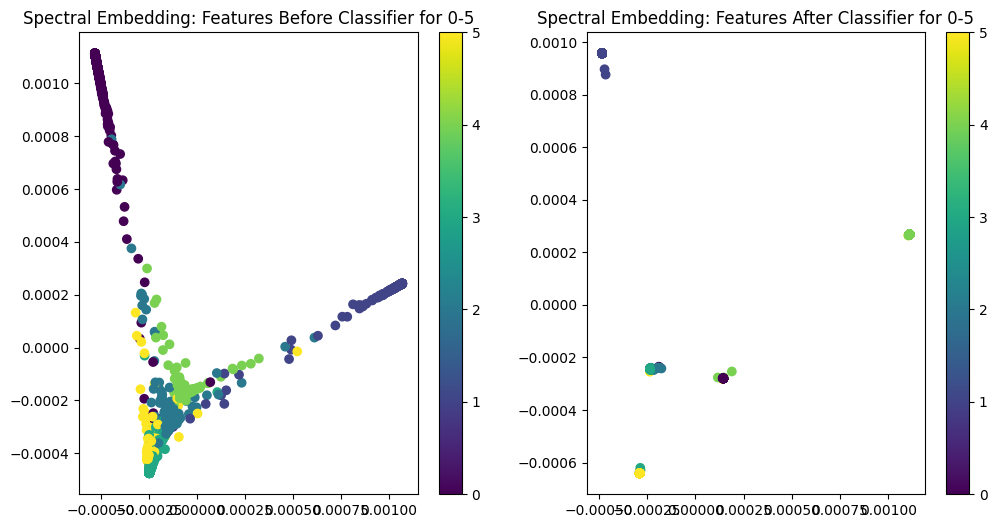

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8968 - loss: 0.3459
Epoch 2/5
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9782 - loss: 0.0697
Epoch 3/5
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9859 - loss: 0.0453
Epoch 4/5
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9897 - loss: 0.0303
Epoch 5/5
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9916 - loss: 0.0244
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


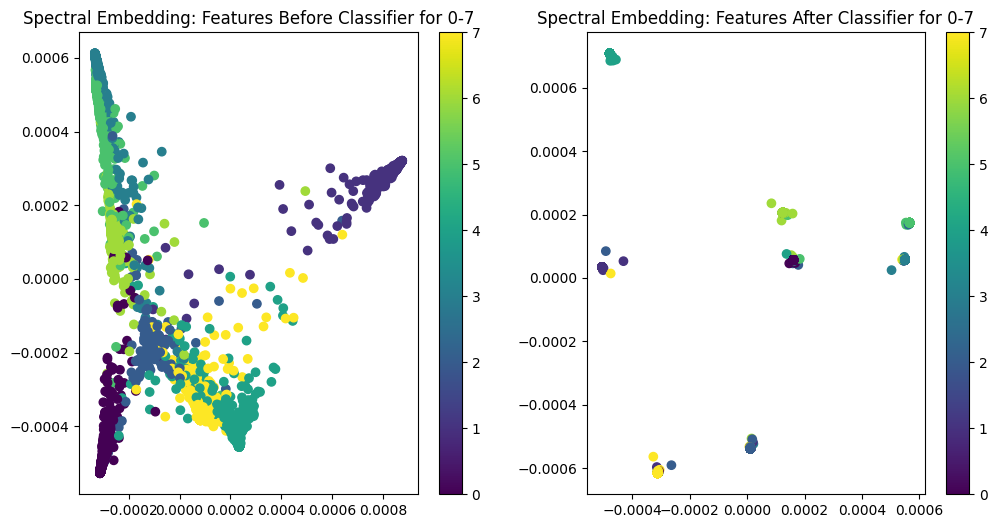

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8716 - loss: 0.4422
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9673 - loss: 0.1064
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9774 - loss: 0.0708
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9829 - loss: 0.0532
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9873 - loss: 0.0409
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


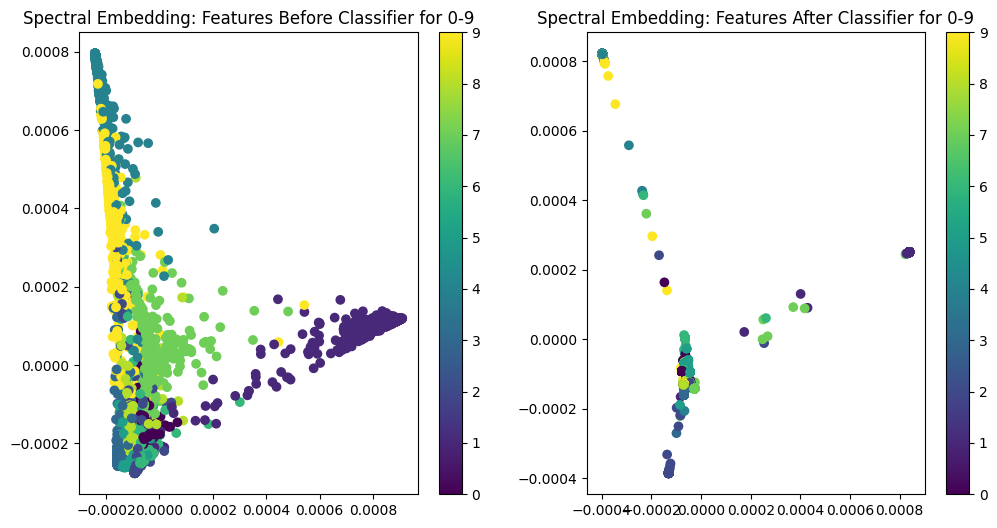

In [57]:
# Call the function for different label ranges
analyze_mnist_with_spectral_embedding(5)  # For labels 0-5
analyze_mnist_with_spectral_embedding(7)  # For labels 0-7
analyze_mnist_with_spectral_embedding(9)  # For labels 0-9

# MDS (Multidimensional Scaling)
GPU optimizable but not on Colab or Kaggle
Very Slow, did not work here

Implemented in MDS_on_Colab.ipynb

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

def analyze_mnist_with_mds(max_label):
    # Load MNIST data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    mask = np.isin(y_train, range(max_label + 1))
    x_train, y_train = x_train[mask], y_train[mask]
    x_train = x_train.reshape(x_train.shape[0], -1).astype('float32') / 255

    mask_test = np.isin(y_test, range(max_label + 1))
    x_test, y_test = x_test[mask_test], y_test[mask_test]
    x_test = x_test.reshape(x_test.shape[0], -1).astype('float32') / 255

    # One-hot encode labels
    y_train = to_categorical(y_train, num_classes=max_label + 1)
    y_test = to_categorical(y_test, num_classes=max_label + 1)

    # Build the DNN model
    model = Sequential([
        Flatten(input_shape=(784,)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(max_label + 1, activation='linear'),  # Features just before classifier head
        Dense(max_label + 1, activation='softmax')  # Features just after classifier head
    ])

    # Compile and train the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=5, batch_size=32)

    # Extract features from both layers
    intermediate_layer_model = Sequential(model.layers[:-1])
    features_before = intermediate_layer_model.predict(x_test)
    features_after = model.predict(x_test)

    # Apply MDS
    mds = MDS(n_components=2, random_state=42)
    mds_features_before = mds.fit_transform(features_before)
    mds_features_after = mds.fit_transform(features_after)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(mds_features_before[:, 0], mds_features_before[:, 1], c=np.argmax(y_test, axis=1), cmap='viridis')
    plt.colorbar()
    plt.title('MDS: Features Before Classifier for 0-{}'.format(max_label))

    plt.subplot(1, 2, 2)
    plt.scatter(mds_features_after[:, 0], mds_features_after[:, 1], c=np.argmax(y_test, axis=1), cmap='viridis')
    plt.colorbar()
    plt.title('MDS: Features After Classifier for 0-{}'.format(max_label))

    plt.show()


In [59]:
# Call the function for different label ranges
analyze_mnist_with_mds(5)  # For labels 0-5

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9198 - loss: 0.2654
Epoch 2/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9824 - loss: 0.0535
Epoch 3/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9906 - loss: 0.0285
Epoch 4/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9935 - loss: 0.0207
Epoch 5/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9948 - loss: 0.0160
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


ValueError: Array must be symmetric

# IsoMAP (Isometric Mapping)

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

def analyze_mnist_with_isomap(max_label):
    # Load MNIST data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    mask = np.isin(y_train, range(max_label + 1))
    x_train, y_train = x_train[mask], y_train[mask]
    x_train = x_train.reshape(x_train.shape[0], -1).astype('float32') / 255

    mask_test = np.isin(y_test, range(max_label + 1))
    x_test, y_test = x_test[mask_test], y_test[mask_test]
    x_test = x_test.reshape(x_test.shape[0], -1).astype('float32') / 255

    # One-hot encode labels
    y_train = to_categorical(y_train, num_classes=max_label + 1)
    y_test = to_categorical(y_test, num_classes=max_label + 1)

    # Build the DNN model
    model = Sequential([
        Flatten(input_shape=(784,)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(max_label + 1, activation='linear'),  # Features just before classifier head
        Dense(max_label + 1, activation='softmax')  # Features just after classifier head
    ])

    # Compile and train the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=5, batch_size=32)

    # Extract features from both layers
    intermediate_layer_model = Sequential(model.layers[:-1])
    features_before = intermediate_layer_model.predict(x_test)
    features_after = model.predict(x_test)

    # Apply Isomap
    isomap = Isomap(n_components=2)
    isomap_features_before = isomap.fit_transform(features_before)
    isomap_features_after = isomap.fit_transform(features_after)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(isomap_features_before[:, 0], isomap_features_before[:, 1], c=np.argmax(y_test, axis=1), cmap='viridis')
    plt.colorbar()
    plt.title('Isomap: Features Before Classifier for 0-{}'.format(max_label))

    plt.subplot(1, 2, 2)
    plt.scatter(isomap_features_after[:, 0], isomap_features_after[:, 1], c=np.argmax(y_test, axis=1), cmap='viridis')
    plt.colorbar()
    plt.title('Isomap: Features After Classifier for 0-{}'.format(max_label))

    plt.show()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9067 - loss: 0.3003
Epoch 2/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9814 - loss: 0.0586
Epoch 3/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9898 - loss: 0.0323
Epoch 4/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9932 - loss: 0.0187
Epoch 5/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9943 - loss: 0.0168
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 10 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/conda/lib/python3.10/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/conda/lib/python3.10/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/conda/lib/python3.10/site-p

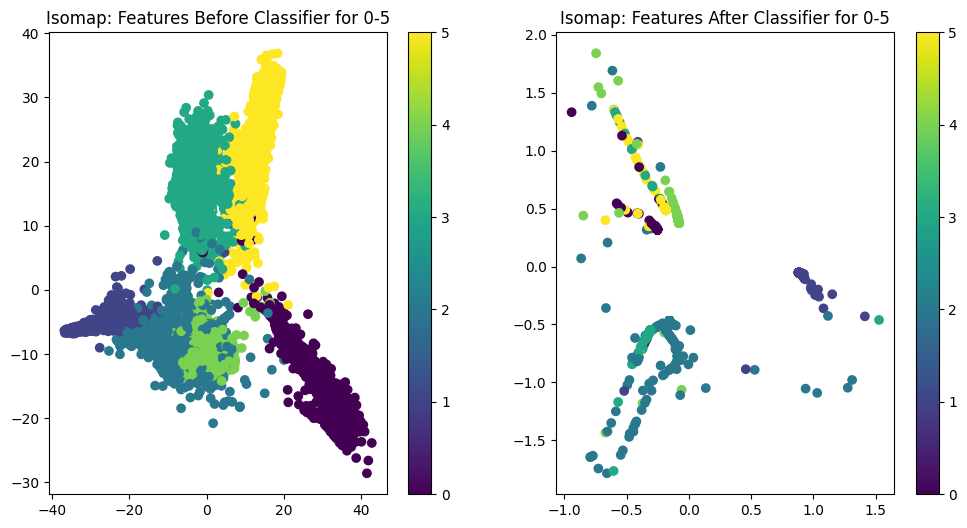

In [61]:
# Call the function for different label ranges
analyze_mnist_with_isomap(5)  # For labels 0-5

# Neighborhood Components Analysis (NCA)

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

def analyze_mnist_with_nca(max_label):
    # Load MNIST data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    mask = np.isin(y_train, range(max_label + 1))
    x_train, y_train = x_train[mask], y_train[mask]
    x_train = x_train.reshape(x_train.shape[0], -1).astype('float32') / 255

    mask_test = np.isin(y_test, range(max_label + 1))
    x_test, y_test = x_test[mask_test], y_test[mask_test]
    x_test = x_test.reshape(x_test.shape[0], -1).astype('float32') / 255

    # One-hot encode labels
    y_train = to_categorical(y_train, num_classes=max_label + 1)
    y_test = to_categorical(y_test, num_classes=max_label + 1)

    # Build the DNN model
    model = Sequential([
        Flatten(input_shape=(784,)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(max_label + 1, activation='linear'),  # Features just before classifier head
        Dense(max_label + 1, activation='softmax')  # Features just after classifier head
    ])

    # Compile and train the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=5, batch_size=32)

    # Extract features from both layers
    intermediate_layer_model = Sequential(model.layers[:-1])
    features_before = intermediate_layer_model.predict(x_test)
    features_after = model.predict(x_test)

    # Apply NCA
    nca = NeighborhoodComponentsAnalysis(n_components=2, random_state=42)
    nca_features_before = nca.fit_transform(features_before, np.argmax(y_test, axis=1))
    nca_features_after = nca.fit_transform(features_after, np.argmax(y_test, axis=1))

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(nca_features_before[:, 0], nca_features_before[:, 1], c=np.argmax(y_test, axis=1), cmap='viridis')
    plt.colorbar()
    plt.title('NCA: Features Before Classifier for 0-{}'.format(max_label))

    plt.subplot(1, 2, 2)
    plt.scatter(nca_features_after[:, 0], nca_features_after[:, 1], c=np.argmax(y_test, axis=1), cmap='viridis')
    plt.colorbar()
    plt.title('NCA: Features After Classifier for 0-{}'.format(max_label))

    plt.show()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9012 - loss: 0.3153
Epoch 2/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9815 - loss: 0.0598
Epoch 3/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9897 - loss: 0.0342
Epoch 4/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9938 - loss: 0.0205
Epoch 5/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9939 - loss: 0.0172
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


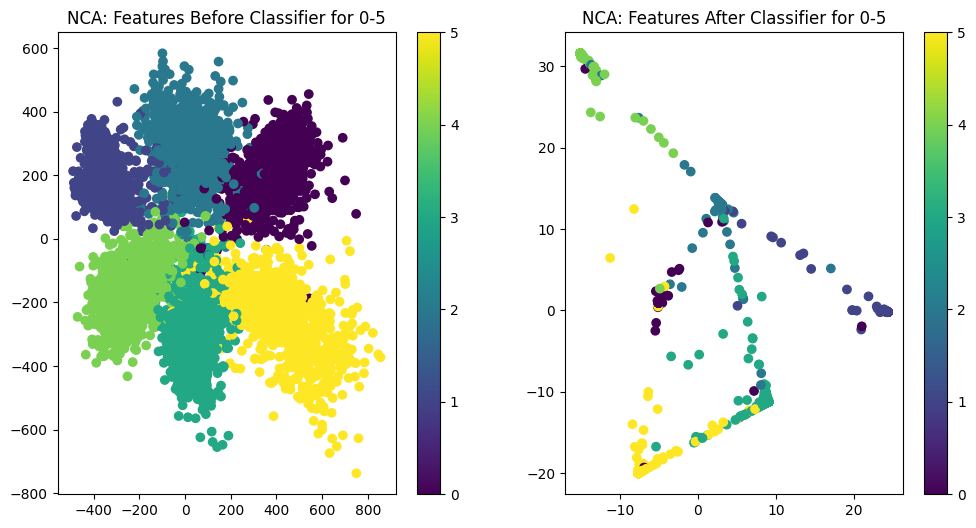

In [63]:
analyze_mnist_with_nca(5)  # For labels 0-5

# Linear Discriminant Analysis (LDA)

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

def analyze_mnist_with_lda(max_label):
    # Load MNIST data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    mask = np.isin(y_train, range(max_label + 1))
    x_train, y_train = x_train[mask], y_train[mask]
    x_train = x_train.reshape(x_train.shape[0], -1).astype('float32') / 255

    mask_test = np.isin(y_test, range(max_label + 1))
    x_test, y_test = x_test[mask_test], y_test[mask_test]
    x_test = x_test.reshape(x_test.shape[0], -1).astype('float32') / 255

    # One-hot encode labels
    y_train = to_categorical(y_train, num_classes=max_label + 1)
    y_test = to_categorical(y_test, num_classes=max_label + 1)

    # Build the DNN model
    model = Sequential([
        Flatten(input_shape=(784,)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(max_label + 1, activation='linear'),  # Features just before classifier head
        Dense(max_label + 1, activation='softmax')  # Features just after classifier head
    ])

    # Compile and train the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=5, batch_size=32)

    # Extract features from both layers
    intermediate_layer_model = Sequential(model.layers[:-1])
    features_before = intermediate_layer_model.predict(x_test)
    features_after = model.predict(x_test)

    # Apply LDA
    lda = LinearDiscriminantAnalysis(n_components=2)
    lda_features_before = lda.fit_transform(features_before, np.argmax(y_test, axis=1))
    lda_features_after = lda.fit_transform(features_after, np.argmax(y_test, axis=1))

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(lda_features_before[:, 0], lda_features_before[:, 1], c=np.argmax(y_test, axis=1), cmap='viridis')
    plt.colorbar()
    plt.title('LDA: Features Before Classifier for 0-{}'.format(max_label))

    plt.subplot(1, 2, 2)
    plt.scatter(lda_features_after[:, 0], lda_features_after[:, 1], c=np.argmax(y_test, axis=1), cmap='viridis')
    plt.colorbar()
    plt.title('LDA: Features After Classifier for 0-{}'.format(max_label))

    plt.show()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9061 - loss: 0.3191
Epoch 2/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9831 - loss: 0.0533
Epoch 3/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9911 - loss: 0.0291
Epoch 4/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9924 - loss: 0.0217
Epoch 5/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9947 - loss: 0.0155
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


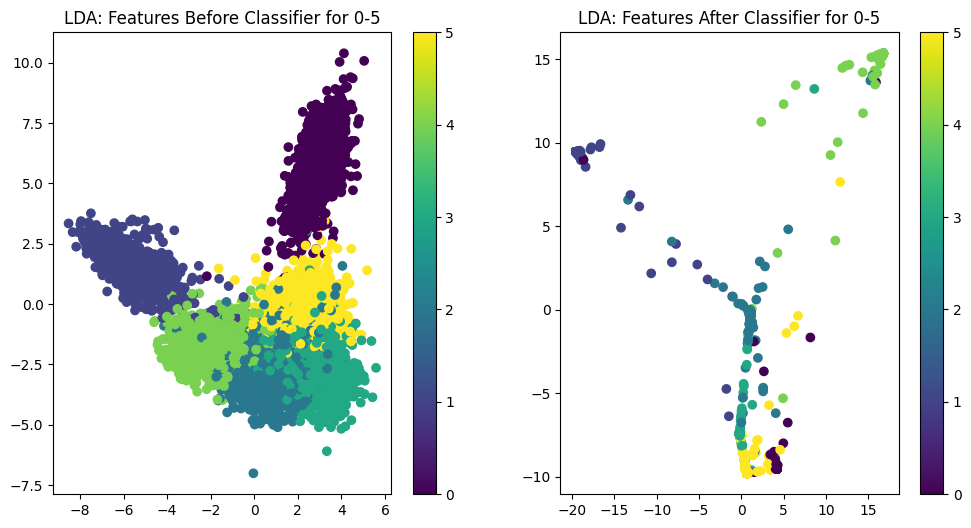

In [65]:
# Call the function for different label ranges
analyze_mnist_with_lda(5)  # For labels 0-5

Common Function for all

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

def analyze_mnist_with_lda(max_label, viz_type):
    # Load MNIST data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    mask = np.isin(y_train, range(max_label + 1))
    x_train, y_train = x_train[mask], y_train[mask]
    x_train = x_train.reshape(x_train.shape[0], -1).astype('float32') / 255

    mask_test = np.isin(y_test, range(max_label + 1))
    x_test, y_test = x_test[mask_test], y_test[mask_test]
    x_test = x_test.reshape(x_test.shape[0], -1).astype('float32') / 255

    # One-hot encode labels
    y_train = to_categorical(y_train, num_classes=max_label + 1)
    y_test = to_categorical(y_test, num_classes=max_label + 1)

    # Build the DNN model
    model = Sequential([
        Flatten(input_shape=(784,)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(max_label + 1, activation='linear'),  # Features just before classifier head
        Dense(max_label + 1, activation='softmax')  # Features just after classifier head
    ])

    # Compile and train the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=5, batch_size=32)

    # Extract features from both layers
    intermediate_layer_model = Sequential(model.layers[:-1])
    features_before = intermediate_layer_model.predict(x_test)
    features_after = model.predict(x_test)

    if (viz_type == 'LDA'):
        # Apply LDA
        lda = LinearDiscriminantAnalysis(n_components=2)
        lda_features_before = lda.fit_transform(features_before, np.argmax(y_test, axis=1))
        lda_features_after = lda.fit_transform(features_after, np.argmax(y_test, axis=1))
    
        # Plotting
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(lda_features_before[:, 0], lda_features_before[:, 1], c=np.argmax(y_test, axis=1), cmap='viridis')
        plt.colorbar()
        plt.title('LDA: Features Before Classifier for 0-{}'.format(max_label))
    
        plt.subplot(1, 2, 2)
        plt.scatter(lda_features_after[:, 0], lda_features_after[:, 1], c=np.argmax(y_test, axis=1), cmap='viridis')
        plt.colorbar()
        plt.title('LDA: Features After Classifier for 0-{}'.format(max_label))

    if (viz_type == 'NCA'):
        # Apply NCA
        nca = NeighborhoodComponentsAnalysis(n_components=2, random_state=42)
        nca_features_before = nca.fit_transform(features_before, np.argmax(y_test, axis=1))
        nca_features_after = nca.fit_transform(features_after, np.argmax(y_test, axis=1))
    
        # Plotting
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(nca_features_before[:, 0], nca_features_before[:, 1], c=np.argmax(y_test, axis=1), cmap='viridis')
        plt.colorbar()
        plt.title('NCA: Features Before Classifier for 0-{}'.format(max_label))
    
        plt.subplot(1, 2, 2)
        plt.scatter(nca_features_after[:, 0], nca_features_after[:, 1], c=np.argmax(y_test, axis=1), cmap='viridis')
        plt.colorbar()
        plt.title('NCA: Features After Classifier for 0-{}'.format(max_label))

    if (viz_type == 'Isomap'):
        # Apply Isomap
        isomap = Isomap(n_components=2)
        isomap_features_before = isomap.fit_transform(features_before)
        isomap_features_after = isomap.fit_transform(features_after)
    
        # Plotting
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(isomap_features_before[:, 0], isomap_features_before[:, 1], c=np.argmax(y_test, axis=1), cmap='viridis')
        plt.colorbar()
        plt.title('Isomap: Features Before Classifier for 0-{}'.format(max_label))
    
        plt.subplot(1, 2, 2)
        plt.scatter(isomap_features_after[:, 0], isomap_features_after[:, 1], c=np.argmax(y_test, axis=1), cmap='viridis')
        plt.colorbar()
        plt.title('Isomap: Features After Classifier for 0-{}'.format(max_label))

    if (viz_type == 'SE'):
        # Apply Spectral Embedding
        spectral_before = SpectralEmbedding(n_components=2, random_state=42)
        spectral_features_before = spectral_before.fit_transform(features_before)
    
        spectral_after = SpectralEmbedding(n_components=2, random_state=42)
        spectral_features_after = spectral_after.fit_transform(features_after)
    
        # Plotting
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(spectral_features_before[:, 0], spectral_features_before[:, 1], c=np.argmax(y_test, axis=1), cmap='viridis')
        plt.colorbar()
        plt.title('Spectral Embedding: Features Before Classifier for 0-{}'.format(max_label))
    
        plt.subplot(1, 2, 2)
        plt.scatter(spectral_features_after[:, 0], spectral_features_after[:, 1], c=np.argmax(y_test, axis=1), cmap='viridis')
        plt.colorbar()
        plt.title('Spectral Embedding: Features After Classifier for 0-{}'.format(max_label))
        
    if (viz_type == 'SOM'):
        # Initialize and train SOM
        som_side_dim = int(np.sqrt(5 * np.sqrt(features_before.shape[0])))  # heuristic for grid size
        som = MiniSom(som_side_dim, som_side_dim, features_before.shape[1], sigma=0.5, learning_rate=0.5)
        som.train(features_before, 500)  # trains the SOM with 500 iterations
    
        # Plotting the result
        plt.figure(figsize=(14, 7))
        plt.subplot(1, 2, 1)
        plt.title('SOM: Features Before Classifier for 0-{}'.format(max_label))
        wmap = {}
        for i, x in enumerate(features_before):
            w = som.winner(x)
            wmap[w] = i
        plt.imshow(som.distance_map())  # shows the distance map from neurons in the SOM
        plt.colorbar()
    
        plt.subplot(1, 2, 2)
        plt.title('SOM: Features After Classifier for 0-{}'.format(max_label))
        som.train(features_after, 500)  # trains the SOM again for features after the classifier
        plt.imshow(som.distance_map())
        plt.colorbar()
        
    if (viz_type == 'tsne'):
        # Apply t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        tsne_features_before = tsne.fit_transform(features_before)
        tsne_features_after = tsne.fit_transform(features_after)
    
        # Plotting
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(tsne_features_before[:, 0], tsne_features_before[:, 1], c=np.argmax(y_test, axis=1), cmap='viridis')
        plt.colorbar()
        plt.title('t-SNE: Features Before Classifier for 0-{}'.format(max_label))
    
        plt.subplot(1, 2, 2)
        plt.scatter(tsne_features_after[:, 0], tsne_features_after[:, 1], c=np.argmax(y_test, axis=1), cmap='viridis')
        plt.colorbar()
        plt.title('t-SNE: Features After Classifier for 0-{}'.format(max_label))

    if (viz_type == 'umap'):
        # Convert features to cuDF DataFrame for UMAP
        features_before_gdf = cudf.DataFrame(features_before)
        features_after_gdf = cudf.DataFrame(features_after)
    
        # Apply UMAP
        umap_transformer = cuml.UMAP(n_components=2)
        umap_features_before = umap_transformer.fit_transform(features_before_gdf)
        umap_features_after = umap_transformer.fit_transform(features_after_gdf)
    
        # Plotting
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(umap_features_before[0].to_numpy(), umap_features_before[1].to_numpy(), c=np.argmax(y_test, axis=1), cmap='viridis')
        plt.colorbar()
        plt.title('UMAP: Features Before Classifier for 0-{}'.format(max_label))
    
        plt.subplot(1, 2, 2)
        plt.scatter(umap_features_after[0].to_numpy(), umap_features_after[1].to_numpy(), c=np.argmax(y_test, axis=1), cmap='viridis')
        plt.colorbar()
        plt.title('UMAP: Features After Classifier for 0-{}'.format(max_label))

    else:
        #code to implement and display all with given <max_label>
    plt.show()

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.manifold import Isomap, SpectralEmbedding, TSNE
from minisom import MiniSom
import cudf
import cuml
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

def analyze_mnist_with_lda(max_label, viz_type):
    # Load MNIST data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    mask = np.isin(y_train, range(max_label + 1))
    x_train, y_train = x_train[mask], y_train[mask]
    x_train = x_train.reshape(x_train.shape[0], -1).astype('float32') / 255

    mask_test = np.isin(y_test, range(max_label + 1))
    x_test, y_test = x_test[mask_test], y_test[mask_test]
    x_test = x_test.reshape(x_test.shape[0], -1).astype('float32') / 255

    # One-hot encode labels
    y_train = to_categorical(y_train, num_classes=max_label + 1)
    y_test = to_categorical(y_test, num_classes=max_label + 1)

    # Build the DNN model
    model = Sequential([
        Flatten(input_shape=(784,)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(max_label + 1, activation='linear'),  # Features just before classifier head
        Dense(max_label + 1, activation='softmax')  # Features just after classifier head
    ])

    # Compile and train the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=5, batch_size=32)

    # Extract features from both layers
    intermediate_layer_model = Sequential(model.layers[:-1])
    features_before = intermediate_layer_model.predict(x_test)
    features_after = model.predict(x_test)

    # Supported visualization techniques
    techniques = {
        'LDA': lambda: LinearDiscriminantAnalysis(n_components=2).fit_transform(features_before, np.argmax(y_test, axis=1)),
        'NCA': lambda: NeighborhoodComponentsAnalysis(n_components=2, random_state=42).fit_transform(features_before, np.argmax(y_test, axis=1)),
        'Isomap': lambda: Isomap(n_components=2).fit_transform(features_before),
        'SE': lambda: SpectralEmbedding(n_components=2, random_state=42).fit_transform(features_before),
        'SOM': lambda: train_som(features_before, features_after),
        'tsne': lambda: TSNE(n_components=2, random_state=42).fit_transform(features_before),
        'umap': lambda: apply_umap(features_before, features_after)
    }

    # Function for SOM training
    def train_som(features_before, features_after):
        som_side_dim = int(np.sqrt(5 * np.sqrt(features_before.shape[0])))  # heuristic for grid size
        som = MiniSom(som_side_dim, som_side_dim, features_before.shape[1], sigma=0.5, learning_rate=0.5)
        som.train(features_before, 500)  # Train SOM
        return som.distance_map()  # Return distance map

    # Function for UMAP
    def apply_umap(features_before, features_after):
        features_before_gdf = cudf.DataFrame(features_before)
        features_after_gdf = cudf.DataFrame(features_after)
        umap_transformer = cuml.UMAP(n_components=2)
        return (
            umap_transformer.fit_transform(features_before_gdf).to_pandas().values,
            umap_transformer.fit_transform(features_after_gdf).to_pandas().values
        )

    if viz_type == "all":
        for key in techniques:
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            features_before_transformed = techniques[key]()
            if key == "SOM":
                plt.imshow(features_before_transformed)
                plt.title(f'{key}: Distance Map Before for 0-{max_label}')
            elif key == "umap":
                plt.scatter(features_before_transformed[0][:, 0], features_before_transformed[0][:, 1], c=np.argmax(y_test, axis=1), cmap='viridis')
                plt.title(f'{key.upper()}: Features Before Classifier for 0-{max_label}')
            else:
                plt.scatter(features_before_transformed[:, 0], features_before_transformed[:, 1], c=np.argmax(y_test, axis=1), cmap='viridis')
                plt.title(f'{key.upper()}: Features Before Classifier for 0-{max_label}')
            
            plt.subplot(1, 2, 2)
            features_after_transformed = techniques[key]()
            if key == "SOM":
                plt.imshow(features_after_transformed)
                plt.title(f'{key}: Distance Map After for 0-{max_label}')
            elif key == "umap":
                plt.scatter(features_after_transformed[1][:, 0], features_after_transformed[1][:, 1], c=np.argmax(y_test, axis=1), cmap='viridis')
                plt.title(f'{key.upper()}: Features After Classifier for 0-{max_label}')
            else:
                plt.scatter(features_after_transformed[:, 0], features_after_transformed[:, 1], c=np.argmax(y_test, axis=1), cmap='viridis')
                plt.title(f'{key.upper()}: Features After Classifier for 0-{max_label}')

            plt.colorbar()
            plt.tight_layout()
            plt.show()

    elif viz_type in techniques:
        features_before_transformed = techniques[viz_type]()
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(features_before_transformed[:, 0], features_before_transformed[:, 1], c=np.argmax(y_test, axis=1), cmap='viridis')
        plt.colorbar()
        plt.title(f'{viz_type.upper()}: Features Before Classifier for 0-{max_label}')

        features_after_transformed = techniques[viz_type]()
        plt.subplot(1, 2, 2)
        plt.scatter(features_after_transformed[:, 0], features_after_transformed[:, 1], c=np.argmax(y_test, axis=1), cmap='viridis')
        plt.colorbar()
        plt.title(f'{viz_type.upper()}: Features After Classifier for 0-{max_label}')

        plt.show()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9092 - loss: 0.2955
Epoch 2/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9813 - loss: 0.0572
Epoch 3/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9881 - loss: 0.0357
Epoch 4/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9929 - loss: 0.0224
Epoch 5/5
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9942 - loss: 0.0173
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


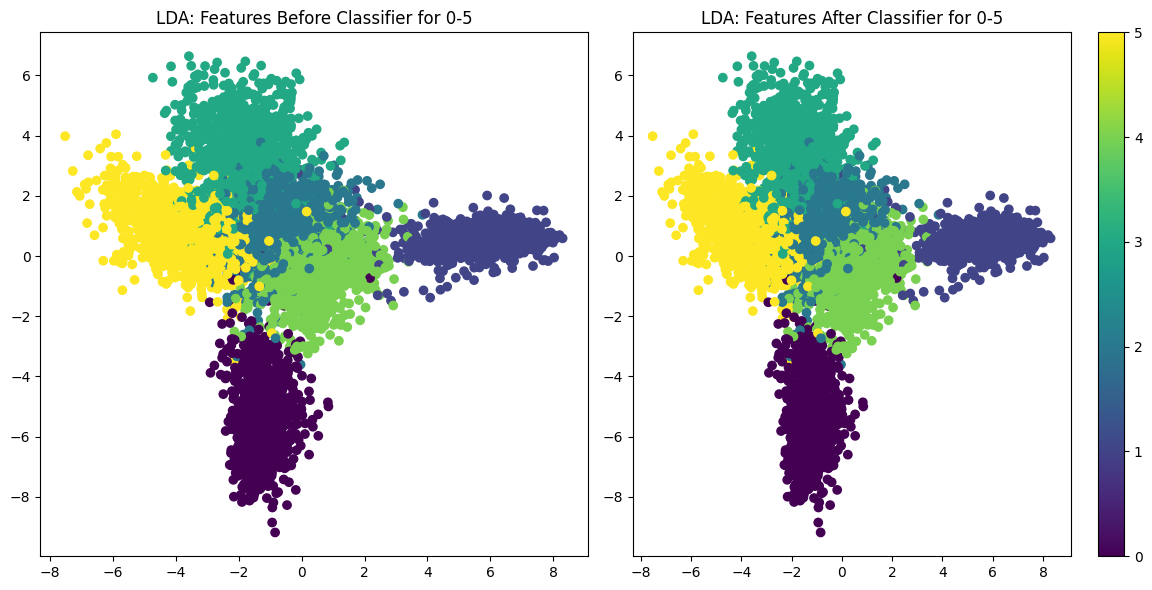

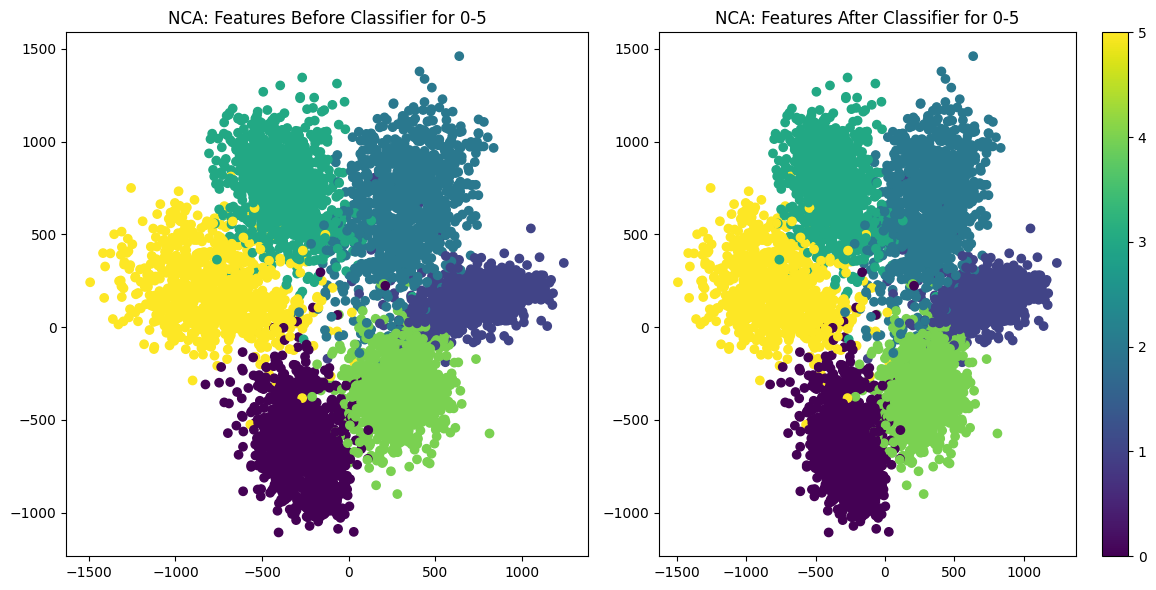

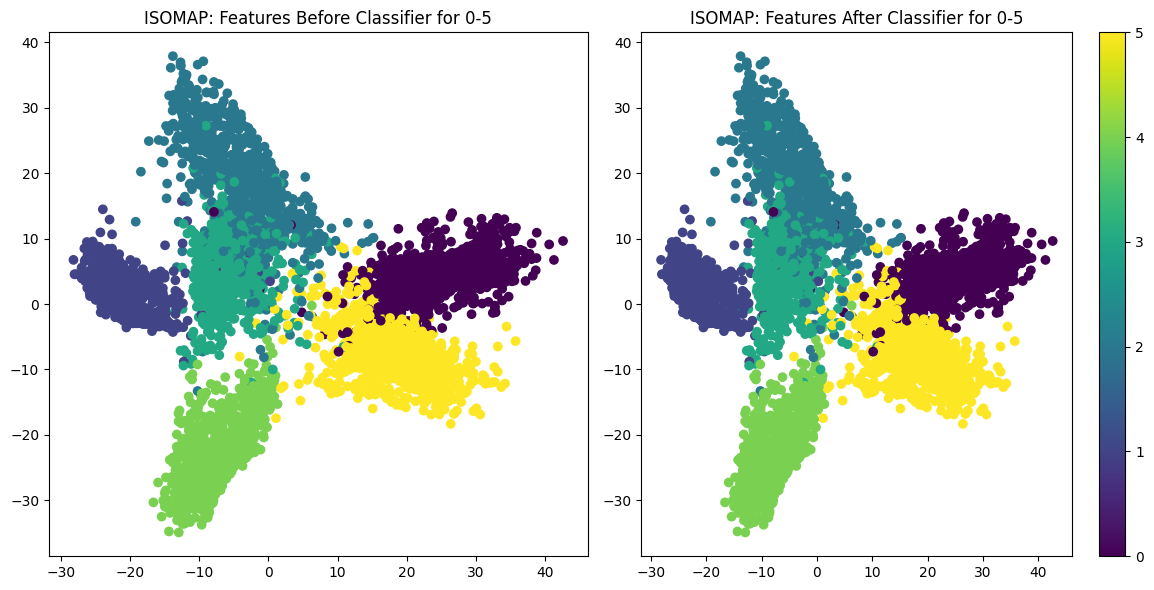

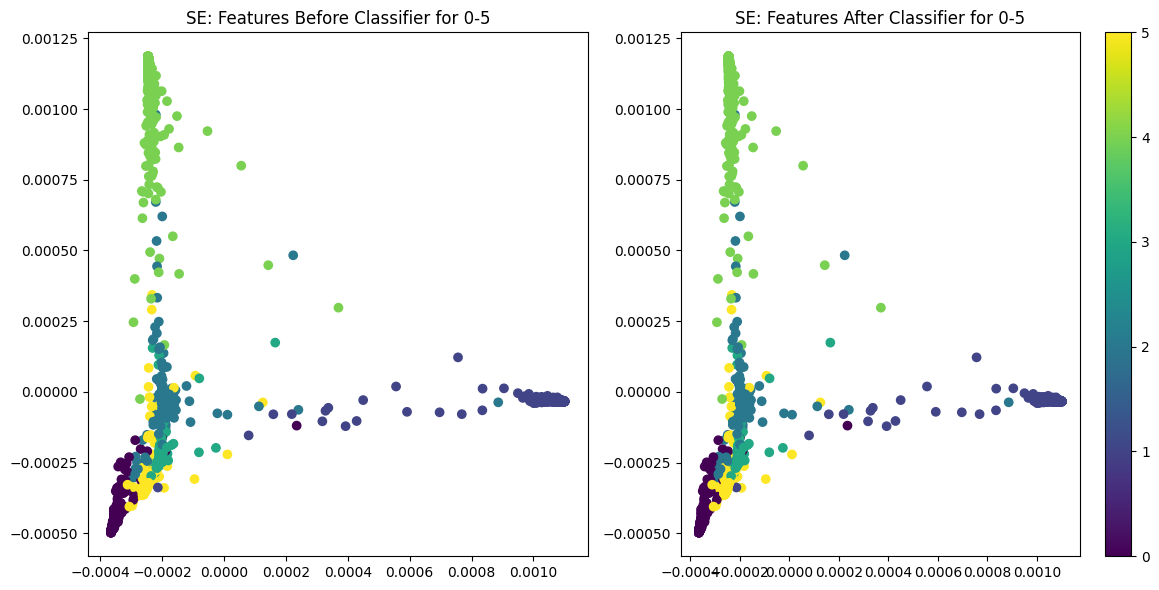

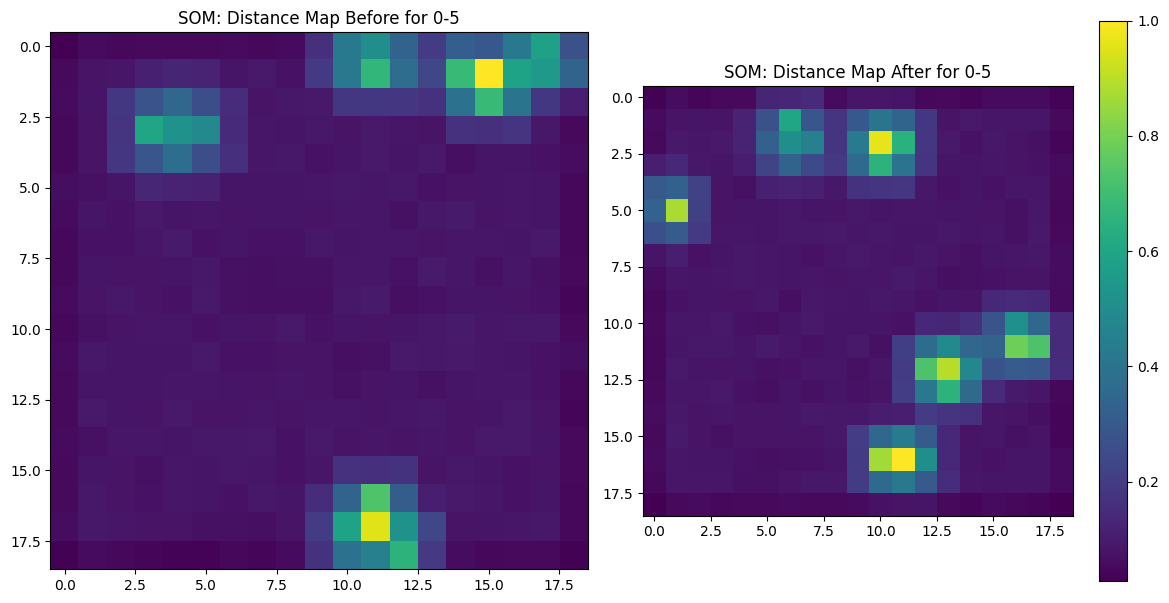

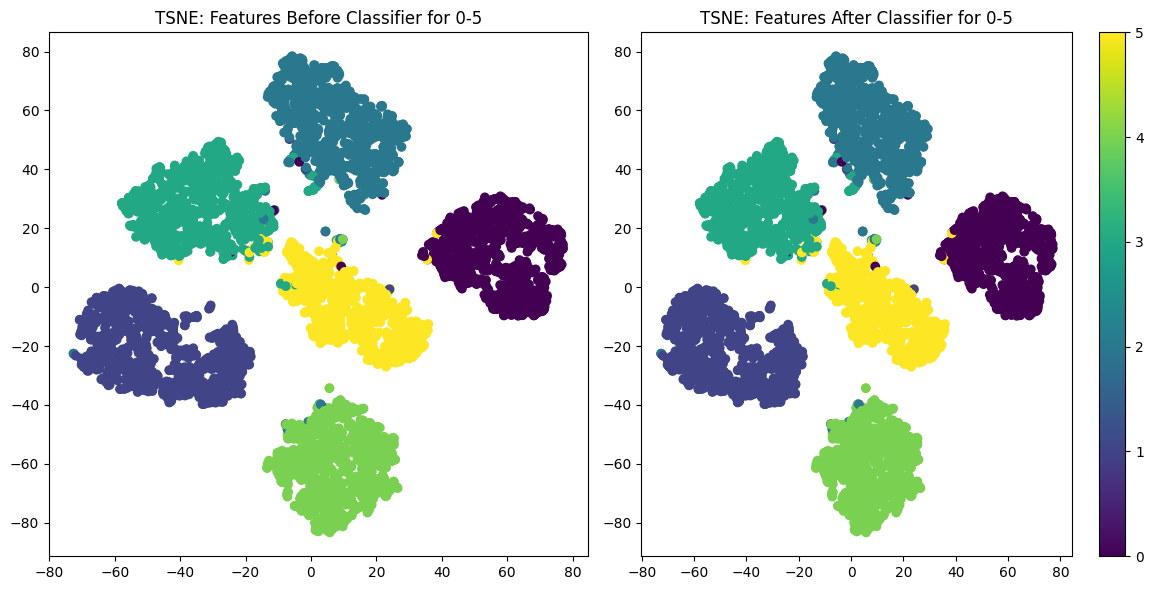

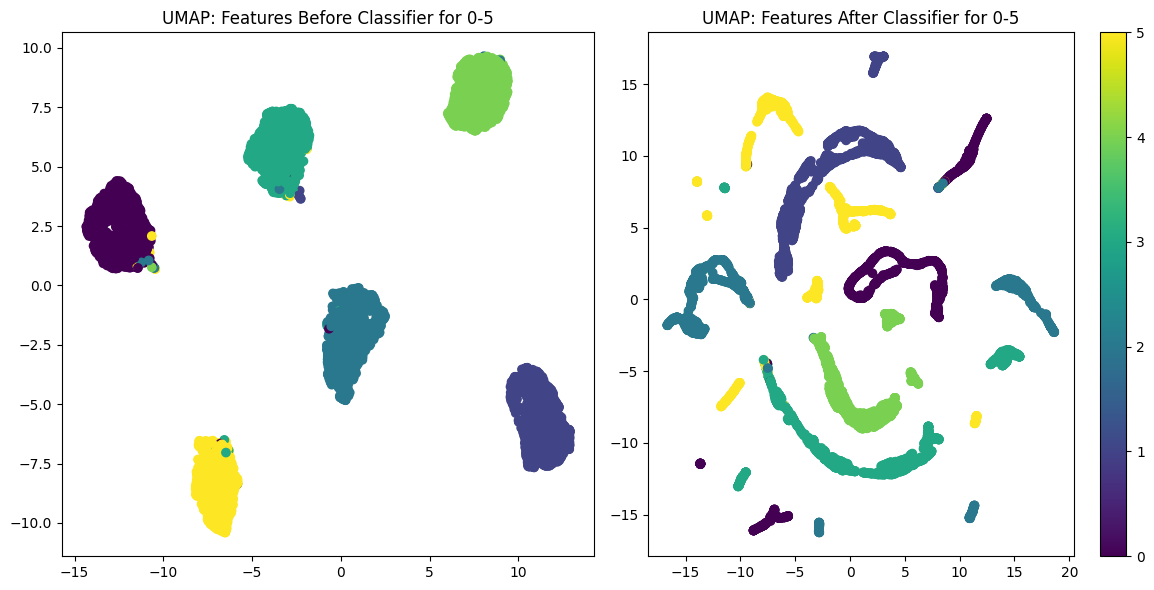

In [67]:
analyze_mnist_with_lda(5, 'all')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8938 - loss: 0.3579
Epoch 2/5
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9771 - loss: 0.0725
Epoch 3/5
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9847 - loss: 0.0504
Epoch 4/5
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9893 - loss: 0.0320
Epoch 5/5
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9913 - loss: 0.0272
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


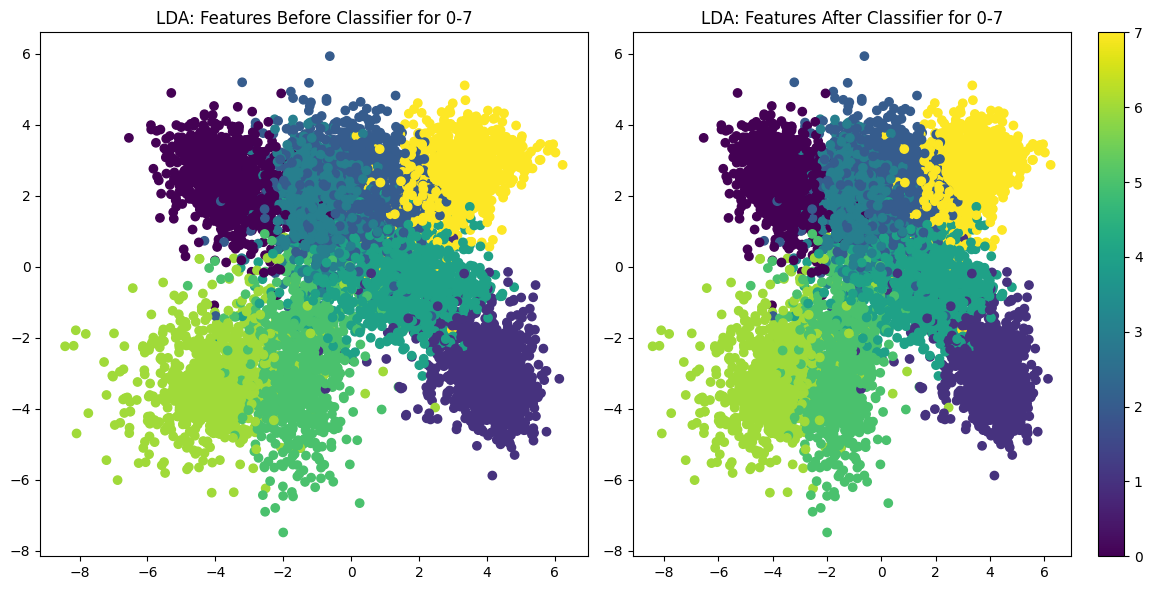

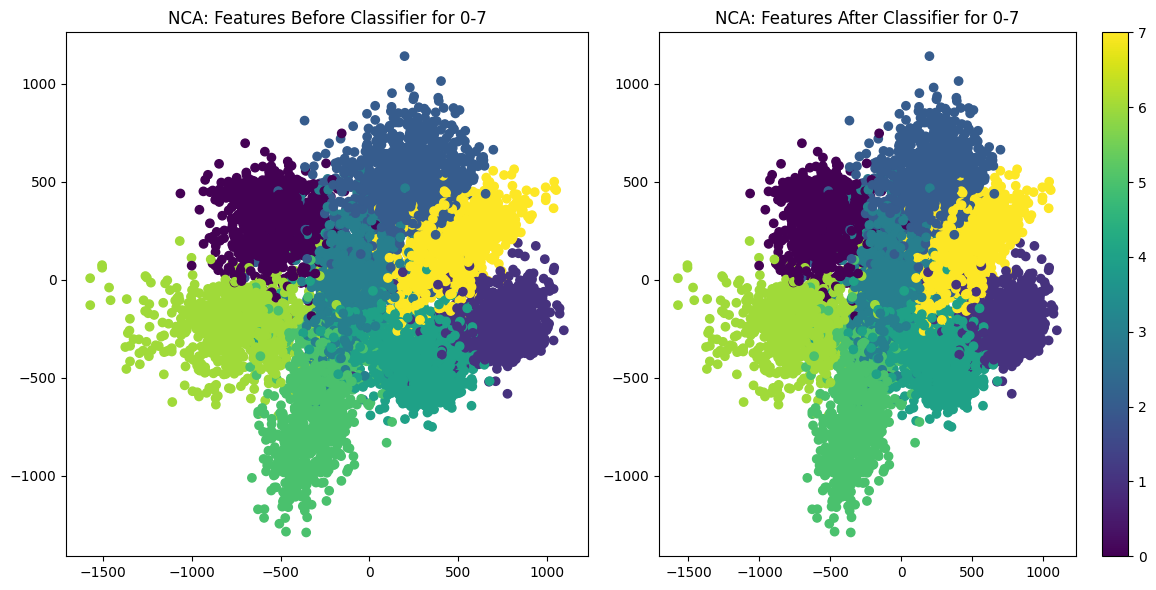

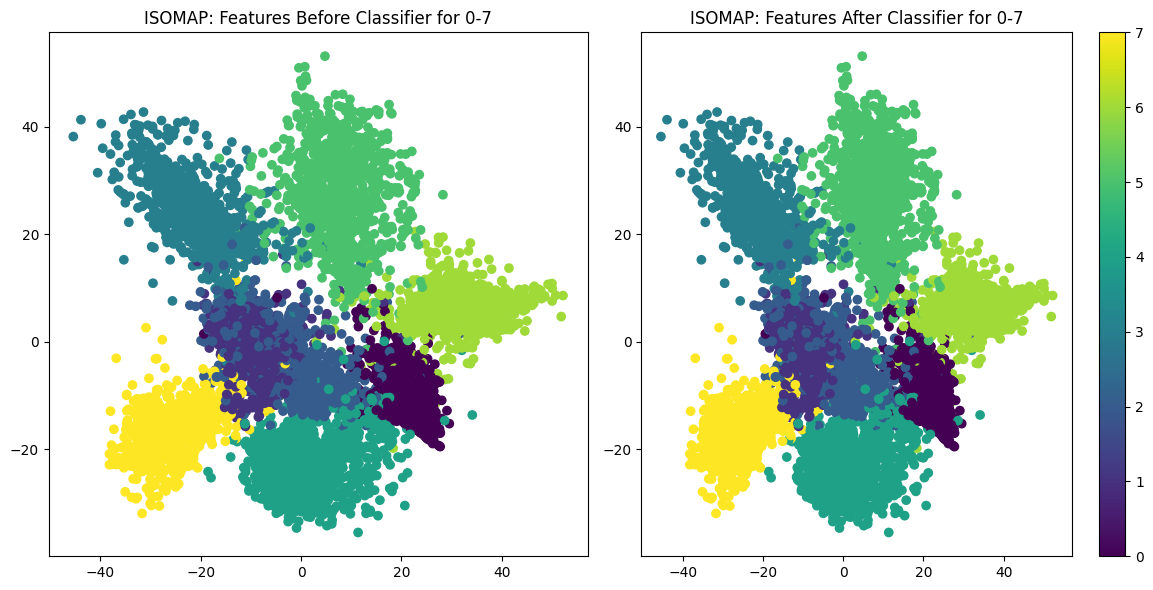

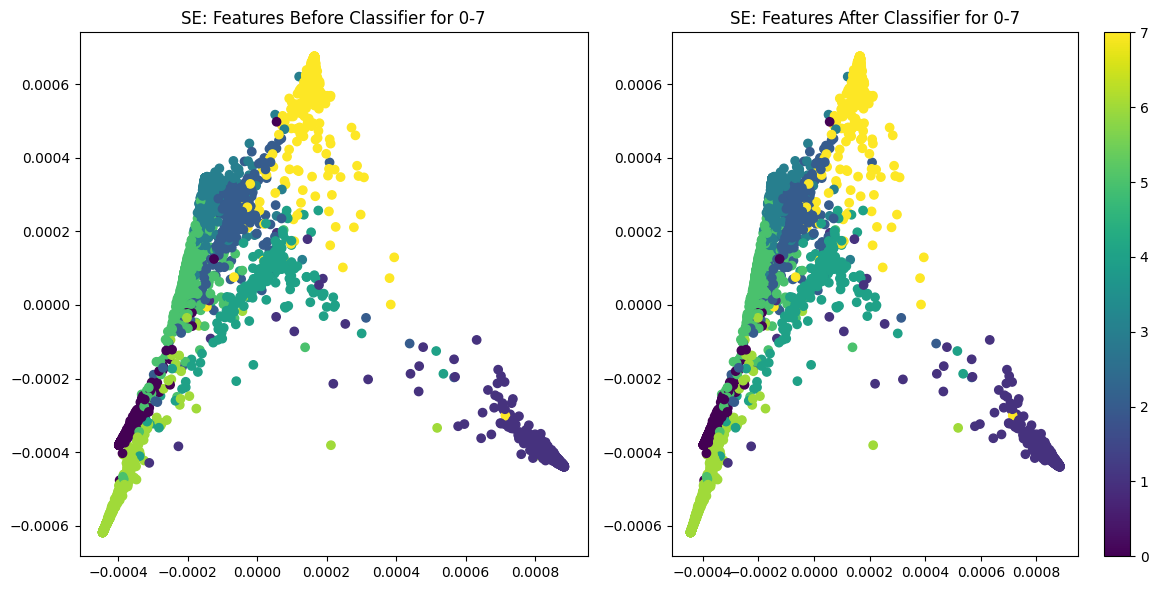

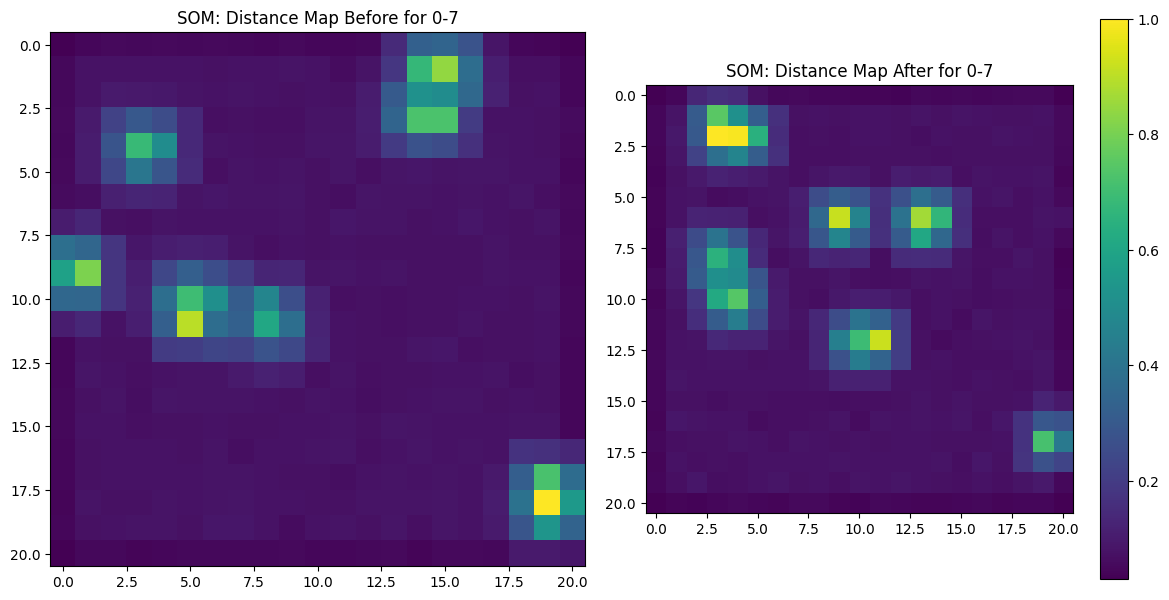

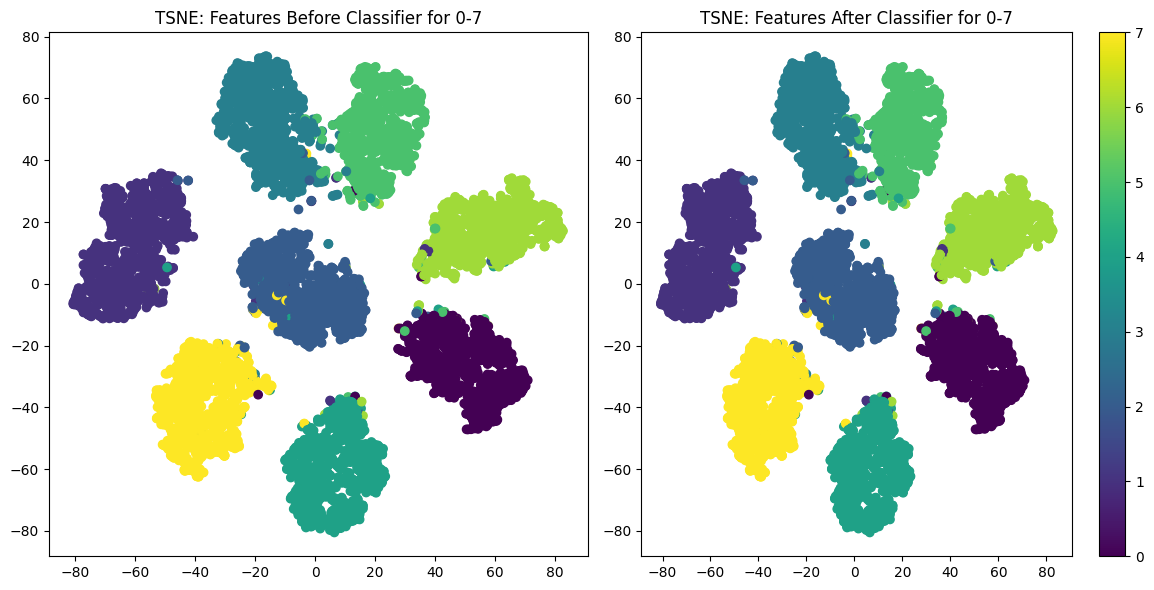

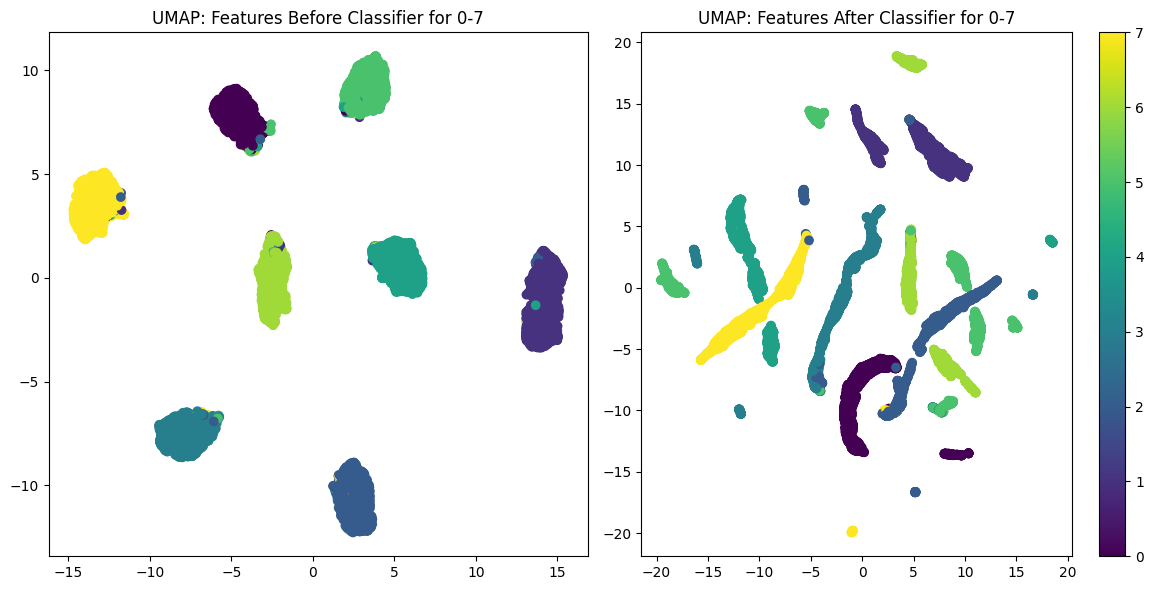

In [68]:
analyze_mnist_with_lda(7, 'all')

# I will update this later for a clearer and more understandable notebook